![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.Clinical_DeIdentification.ipynb)


# Clinical Deidentification

## Colab Setup

In [ ]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:

# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.5.0  spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [3]:
import json
import os

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.util import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp_jsl.pipeline_tracer import PipelineTracer
from sparknlp_jsl.pipeline_output_parser import PipelineOutputParser

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline, PipelineModel

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import string
import numpy as np


params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(secret = license_keys["SECRET"], params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 6.1.3
Spark NLP_JSL Version : 6.1.1


In [4]:
# if you want to start the session with custom params as in start function above
from pyspark.sql import SparkSession

def start(SECRET):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:"+PUBLIC_VERSION) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+SECRET+"/spark-nlp-jsl-"+JSL_VERSION+".jar")

    return builder.getOrCreate()

#spark = start(SECRET)

## Healthcare NLP for Data Scientists Course

If you are not familiar with the components in this notebook, you can check [Healthcare NLP for Data Scientists Udemy Course](https://www.udemy.com/course/healthcare-nlp-for-data-scientists/) and the [MOOC Notebooks](https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/Spark_NLP_Udemy_MOOC/Healthcare_NLP) for each components.

# Deidentification Model

Protected Health Information:
- individual’s past, present, or future physical or mental health or condition
- provision of health care to the individual
- past, present, or future payment for the health care

Protected health information includes many common identifiers (e.g., name, address, birth date, Social Security Number) when they can be associated with the health information.

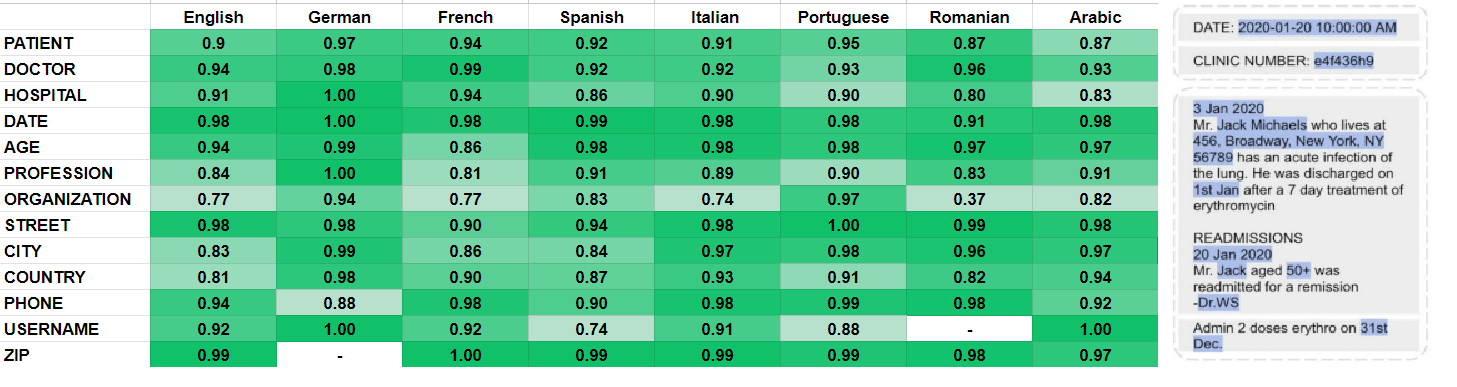

<center><b>Deidentification NER Models for English</b></center>

|index|model|lang|index|model|lang|index|model|lang|
|-----:|:-----|----|-----:|:-----|----|-----:|:-----|----|
| 1| [deidentify_dl](https://nlp.johnsnowlabs.com/2021/01/28/deidentify_dl_en.html)  |en| 9| [ner_deid_generic_augmented](https://nlp.johnsnowlabs.com/2021/06/30/ner_deid_generic_augmented_en.html)  |en| 16| [ner_deid_synthetic](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_synthetic_en.html)  |en|
| 2| [deidentify_large](https://nlp.johnsnowlabs.com/2020/08/04/deidentify_large_en.html)  |en| 10| [ner_deid_generic_glove](https://nlp.johnsnowlabs.com/2021/06/06/ner_deid_generic_glove_en.html)  |en| 17| [ner_deidentify_dl](https://nlp.johnsnowlabs.com/2021/03/31/ner_deidentify_dl_en.html)  |en|
| 3| [deidentify_rb](https://nlp.johnsnowlabs.com/2019/06/04/deidentify_rb_en.html)  |en| 11| [ner_deid_large](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_large_en.html)  |en| 18| [ner_deid_generic_docwise](https://nlp.johnsnowlabs.com/2024/09/25/ner_deid_generic_docwise_en.html)  |en|
| 4| [ner_deid_augmented](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_augmented_en.html)  |en| 12| [ner_deid_sd](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_sd_en.html)  |en| 19| [ner_deid_subentity_augmented_docwise](https://nlp.johnsnowlabs.com/2024/09/25/ner_deid_subentity_augmented_docwise_en.html)  |en|
| 5| [ner_deid_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_biobert_en.html)  |en| 13| [ner_deid_sd_large](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_sd_large_en.html)  |en| 20| [ner_deid_subentity_docwise](https://nlp.johnsnowlabs.com/2024/09/25/ner_deid_subentity_docwise_en.html)  |en|
| 6| [ner_deid_enriched](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_enriched_en.html)  |en| 14| [ner_deid_subentity_augmented](https://nlp.johnsnowlabs.com/2021/09/03/ner_deid_subentity_augmented_en.html)  |en| 21| [ner_deid_aipii](https://nlp.johnsnowlabs.com/2024/09/25/ner_deid_aipii_en.html)  |en|
| 7| [ner_deid_enriched_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_enriched_biobert_en.html)  |en| 15| [ner_deid_subentity_glove](https://nlp.johnsnowlabs.com/2021/06/06/ner_deid_subentity_glove_en.html)  |en| 22|  [zeroshot_ner_deid_subentity_docwise_large](https://nlp.johnsnowlabs.com/2024/11/29/zeroshot_ner_deid_subentity_docwise_large_en.html) | en|
| 8| [deidentify_enriched_clinical](https://nlp.johnsnowlabs.com/2021/01/29/deidentify_enriched_clinical_en.html)  |en|

|index|model|lang|index|model|lang|index|model|lang|
|-----:|:-----|----|-----:|:-----|----|-----:|:-----|----|
| 1| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/01/06/ner_deid_generic_de.html)  |de| 12| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/02/11/ner_deid_generic_fr.html)  |fr| 22| [ner_deid_subentity_roberta_augmented](https://nlp.johnsnowlabs.com/2022/02/16/ner_deid_subentity_roberta_augmented_es.html)  |es
| 2| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/01/06/ner_deid_subentity_de.html)  |de| 13| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/02/14/ner_deid_subentity_fr.html)  |fr| 23| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2023/05/31/ner_deid_subentity_ar.html)  |ar|
| 3| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/01/18/ner_deid_generic_es.html)  |es| 14| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/03/25/ner_deid_generic_it_3_0.html)  |it|24|[ner_deid_subentity_arabert](https://nlp.johnsnowlabs.com/2023/09/16/ner_deid_subentity_arabert_en.html)   |ar|
| 4| [ner_deid_generic_augmented](https://nlp.johnsnowlabs.com/2022/02/16/ner_deid_generic_augmented_es.html)  |es| 15| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/03/25/ner_deid_subentity_it_2_4.html)  |it| 25| [ner_deid_subentity_camelbert](https://nlp.johnsnowlabs.com/2023/09/22/ner_deid_subentity_camelbert_en.html) |ar|
| 5| [ner_deid_generic_roberta](https://nlp.johnsnowlabs.com/2022/01/17/ner_deid_generic_roberta_es.html)  |es| 16| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/04/13/ner_deid_generic_pt_3_0.html)  |pt| 26| [ner_deid_generic_bert](https://nlp.johnsnowlabs.com/2022/11/22/ner_deid_generic_bert_ro.html)  |ro
| 6| [ner_deid_generic_roberta_augmented](https://nlp.johnsnowlabs.com/2022/02/16/ner_deid_generic_roberta_augmented_es.html)  |es| 17| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/04/13/ner_deid_subentity_pt_3_0.html)  |pt|27| [ner_deid_generic](https://nlp.johnsnowlabs.com/2023/05/30/ner_deid_generic_ar.html)  |ar|
| 7| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/01/18/ner_deid_subentity_es.html)  |es| 18| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/06/27/ner_deid_subentity_ro_3_0.html)  |ro|28|[ner_deid_generic_arabert](https://nlp.johnsnowlabs.com/2023/09/16/ner_deid_generic_arabert_en.html)   |ar|
| 8| [ner_deid_subentity_augmented](https://nlp.johnsnowlabs.com/2022/02/16/ner_deid_subentity_augmented_es.html)  |es| 19| [ner_deid_subentity_bert](https://nlp.johnsnowlabs.com/2022/06/27/ner_deid_subentity_bert_ro_3_0.html)  |ro|29| [ner_deid_generic_camelbert](https://nlp.johnsnowlabs.com/2023/09/16/ner_deid_generic_camelbert_en.html) |ar|
| 9| [ner_deid_subentity_roberta](https://nlp.johnsnowlabs.com/2022/01/17/ner_deid_subentity_roberta_es.html)  |es| 20| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/07/08/ner_deid_generic_ro_3_0.html)  |ro| 30| [zeroshot_ner_deid_generic_docwise_large](https://nlp.johnsnowlabs.com/2024/11/28/zeroshot_ner_deid_generic_docwise_large_de.html)  |de|
| 10| [ner_deid_generic](https://nlp.johnsnowlabs.com/2023/05/30/ner_deid_generic_ar.html)  |ar| 21| [ner_deid_generic_docwise](https://nlp.johnsnowlabs.com/2024/11/28/ner_deid_generic_docwise_de.html)  |de| 31| [ner_deid_multilingual](https://nlp.johnsnowlabs.com/2024/02/12/ner_deid_multilingual_xx.html)  |xx|
| 11| [ner_deid_subentity_langtest](https://nlp.johnsnowlabs.com/2024/10/24/ner_deid_subentity_langtest_de.html)  |de|

You can find German, Spanish, French, Italian, Portuguese and Romanian deidentification models and pretrained pipeline examples in this notebook:   [Clinical Multi Language Deidentification Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.1.Clinical_Multi_Language_Deidentification.ipynb)


**Let's start!**

Load NER pipeline to identify protected entities:

In [5]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER model trained on n2c2 (de-identification and Heart Disease Risk Factors Challenge) datasets)
clinical_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_generic_augmented download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


### Pretrained NER models extracts:

- Name
- Profession
- Age
- Date
- Contact(Telephone numbers, FAX numbers, Email addresses)
- Location (Address, City, Postal code, Hospital Name, Employment information)
- Id (Social Security numbers, Medical record numbers, Internet protocol addresses)

In [6]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 . PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital , 0295 Keats Street , Phone 55-555-5555 .
'''

In [7]:
result = model.transform(spark.createDataFrame([[text]]).toDF("text"))

In [8]:
result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.ner.result)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("ner_label"))

In [9]:
result_df.select("token", "ner_label").groupBy('ner_label').count().orderBy('count', ascending=False).show(truncate=False)

+----------+-----+
|ner_label |count|
+----------+-----+
|O         |29   |
|I-LOCATION|5    |
|B-NAME    |3    |
|B-DATE    |3    |
|B-LOCATION|2    |
|I-NAME    |2    |
|B-ID      |1    |
|B-AGE     |1    |
|B-CONTACT |1    |
+----------+-----+



### Check extracted sensitive entities

In [10]:
result.select(F.explode(F.arrays_zip(result.ner_chunk.result,
                                     result.ner_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+-----------------------------+---------+
|chunk                        |ner_label|
+-----------------------------+---------+
|2093-01-13                   |DATE     |
|David Hale                   |NAME     |
|Hendrickson Ora              |NAME     |
|7194334                      |ID       |
|01/13/93                     |DATE     |
|Oliveira                     |NAME     |
|25                           |AGE      |
|2079-11-09                   |DATE     |
|Cocke County Baptist Hospital|LOCATION |
|0295 Keats Street            |LOCATION |
|55-555-5555                  |CONTACT  |
+-----------------------------+---------+



### Excluding entities from deidentification

Sometimes we need to leave some entities in the text, for example, if we want to analyze the frequency of the disease by the hospital. In this case, we need to use parameter **`setWhiteList()`** to modify `ner_chunk` output. This parameter having using a list of entities type to deidentify as an input. So, if we want to leave the location in the list we need to remove this tag from the list:

In [11]:
ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk") \
    .setWhiteList(['NAME', 'PROFESSION', 'ID', 'AGE', 'DATE'])

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_with_white_list = nlpPipeline.fit(empty_data)

In [12]:
result_with_white_list = model_with_white_list.transform(spark.createDataFrame([[text]]).toDF("text"))

In [13]:
print("All Labels :")
result.select(F.explode(F.arrays_zip(result.ner_chunk.result,
                                     result.ner_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

print("WhiteListed Labels: ")
result_with_white_list.select(F.explode(F.arrays_zip(result_with_white_list.ner_chunk.result,
                                                     result_with_white_list.ner_chunk.metadata)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("chunk"),
                              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

All Labels :
+-----------------------------+---------+
|chunk                        |ner_label|
+-----------------------------+---------+
|2093-01-13                   |DATE     |
|David Hale                   |NAME     |
|Hendrickson Ora              |NAME     |
|7194334                      |ID       |
|01/13/93                     |DATE     |
|Oliveira                     |NAME     |
|25                           |AGE      |
|2079-11-09                   |DATE     |
|Cocke County Baptist Hospital|LOCATION |
|0295 Keats Street            |LOCATION |
|55-555-5555                  |CONTACT  |
+-----------------------------+---------+

WhiteListed Labels: 
+---------------+---------+
|chunk          |ner_label|
+---------------+---------+
|2093-01-13     |DATE     |
|David Hale     |NAME     |
|Hendrickson Ora|NAME     |
|7194334        |ID       |
|01/13/93       |DATE     |
|Oliveira       |NAME     |
|25             |AGE      |
|2079-11-09     |DATE     |
+---------------+---------+

## Masking and Obfuscation

### Replace these enitites with Tags

In [14]:
ner_converter = NerConverterInternal()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk")

deidentification = DeIdentification() \
      .setInputCols(["sentence", "token", "ner_chunk"]) \
      .setOutputCol("deidentified") \
      .setMode("mask")\
      .setReturnEntityMappings(True) #  return a new column to save the mappings between the mask/obfuscated entities and original entities.
      #.setMappingsColumn("MappingCol") # change the name of the column, 'aux' is default

deidPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter,
        deidentification
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_deid = deidPipeline.fit(empty_data)

In [15]:
result = model_deid.transform(spark.createDataFrame([[text]]).toDF("text"))

In [16]:
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|        deidentified|                 aux|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|\nRecord date : 2...|[{document, 0, 23...|[{document, 1, 45...|[{token, 1, 6, Re...|[{word_embeddings...|[{named_entity, 1...|[{chunk, 15, 24, ...|[{document, 0, 36...|[{chunk, 14, 19, ...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+



In [17]:
result.select(F.explode(F.arrays_zip(result.sentence.result,
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"),
              F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : <DATE> , <NAME> , M.D ."
1,", Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 .",", Name : <NAME> , MR # <ID> Date : <DATE> ."
2,"PCP : Oliveira , 25 years-old , Record date : 2079-11-09 .","PCP : <NAME> , <AGE> years-old , Record date : <DATE> ."
3,"Cocke County Baptist Hospital , 0295 Keats Street , Phone 55-555-5555 .","<LOCATION> , <LOCATION> , Phone <CONTACT> ."


In [18]:
result.select(  "deidentified").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|deidentified                                                                                                                                                                                                                                                                                                                                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------

### PipelineOutputParser
Lets get results with `PipelineOutputParser`

In [19]:
light_model = LightPipeline(model_deid)

light_result = light_model.fullAnnotate(text)

In [20]:
column_maps = {
    'document_identifier': 'clinical_deidentification_pipeline',
    'document_text': 'document',
    'entities': ['ner_chunk'],
    'assertions': [],
    'resolutions': [],
    'relations': [],
    'summaries': [],
    'deidentifications': [{
        'original': 'document',
        'masked': 'deidentified',
        'obfuscated': ''}
    ],
    'classifications': []
}

pipeline_parser = PipelineOutputParser(column_maps)
parser_result = pipeline_parser.run(light_result)

In [21]:
df_deid = pd.DataFrame.from_dict(parser_result["result"][0]["deidentifications"]).drop(columns=["obfuscated"])
df_deid

,original,masked
0,"[\nRecord date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 . PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital , 0295 Keats Street , Phone 55-555-5555 .\n]","[Record date : <DATE> , <NAME> , M.D ., , Name : <NAME> , MR # <ID> Date : <DATE> ., PCP : <NAME> , <AGE> years-old , Record date : <DATE> ., <LOCATION> , <LOCATION> , Phone <CONTACT> ., <DATE>, <NAME>, <NAME>, <ID>, <DATE>, <NAME>, <AGE>, <DATE>, <LOCATION>, <LOCATION>, <CONTACT>]"


We have three modes to mask the entities in the Deidentification annotator. You can select the modes using the `.setMaskingPolicy()` parameter. The methods are the followings:

**“entity_labels”**: Mask with the entity type of that chunk. (default) <br/>
**“same_length_chars”**: Mask the deid entities with same length of asterix ( * ) with brackets ( [ , ] ) on both end. <br/>
**“fixed_length_chars”**: Mask the deid entities with a fixed length of asterix ( * ). The length is setting up using the `setFixedMaskLength()` method. <br/>
Let's try each of these and compare the results.

In [22]:
#deid model with "entity_labels"
deid_entity_labels= DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"])\
    .setOutputCol("deid_entity_label")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("entity_labels")

#deid model with "same_length_chars"
deid_same_length= DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"])\
    .setOutputCol("deid_same_length")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("same_length_chars")

#deid model with "fixed_length_chars"
deid_fixed_length= DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"])\
    .setOutputCol("deid_fixed_length")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("fixed_length_chars")\
    .setFixedMaskLength(4)

deidPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter,
        deid_entity_labels,
        deid_same_length,
        deid_fixed_length
])


empty_data = spark.createDataFrame([[""]]).toDF("text")
model_deid = deidPipeline.fit(empty_data)

In [23]:
policy_result = model_deid.transform(spark.createDataFrame([[text]]).toDF("text"))

In [24]:
policy_result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|   deid_entity_label|                 aux|    deid_same_length|   deid_fixed_length|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|\nRecord date : 2...|[{document, 0, 23...|[{document, 1, 45...|[{token, 1, 6, Re...|[{word_embeddings...|[{named_entity, 1...|[{chunk, 15, 24, ...|[{document, 0, 36...|[{chunk, 14, 17, ...|[{document, 0, 44...|[{document, 0, 32...|
+--------------------+--------------------+--------------------+----

In [25]:
policy_result.select(F.explode(F.arrays_zip(policy_result.sentence.result,
                                            policy_result.deid_entity_label.result,
                                            policy_result.deid_same_length.result,
                                            policy_result.deid_fixed_length.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("sentence"),
                     F.expr("cols['1']").alias("deid_entity_label"),
                     F.expr("cols['2']").alias("deid_same_length"),
                     F.expr("cols['3']").alias("deid_fixed_length")).toPandas()

,sentence,deid_entity_label,deid_same_length,deid_fixed_length
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : <DATE> , <NAME> , M.D .","Record date : [********] , [********] , M.D .","Record date : **** , **** , M.D ."
1,", Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 .",", Name : <NAME> , MR # <ID> Date : <DATE> .",", Name : [*************] , MR # [*****] Date : [******] .",", Name : **** , MR # **** Date : **** ."
2,"PCP : Oliveira , 25 years-old , Record date : 2079-11-09 .","PCP : <NAME> , <AGE> years-old , Record date : <DATE> .","PCP : [******] , ** years-old , Record date : [********] .","PCP : **** , **** years-old , Record date : **** ."
3,"Cocke County Baptist Hospital , 0295 Keats Street , Phone 55-555-5555 .","<LOCATION> , <LOCATION> , Phone <CONTACT> .","[***************************] , [***************] , Phone [*********] .","**** , **** , Phone **** ."


### Mapping Column

In [26]:
result.select("aux").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
result.select(F.explode(F.arrays_zip(result.aux.metadata,
                                     result.aux.result,
                                     result.aux.begin,
                                     result.aux.end)).alias("cols")) \
      .select(F.expr("cols['0']['originalChunk']").alias("chunk"),
              F.expr("cols['0']['beginOriginalChunk']").alias("beginChunk"),
              F.expr("cols['0']['endOriginalChunk']").alias("endChunk"),
              F.expr("cols['1']").alias("label"),
              F.expr("cols['2']").alias("beginLabel"),
              F.expr("cols['3']").alias("endLabel")).show(truncate=False)

+-----------------------------+----------+--------+----------+----------+--------+
|chunk                        |beginChunk|endChunk|label     |beginLabel|endLabel|
+-----------------------------+----------+--------+----------+----------+--------+
|2093-01-13                   |15        |24      |<DATE>    |14        |19      |
|David Hale                   |28        |37      |<NAME>    |23        |28      |
|Hendrickson Ora              |56        |70      |<NAME>    |46        |51      |
|7194334                      |79        |85      |<ID>      |60        |63      |
|01/13/93                     |94        |101     |<DATE>    |72        |77      |
|Oliveira                     |111       |118     |<NAME>    |86        |91      |
|25                           |122       |123     |<AGE>     |95        |99      |
|2079-11-09                   |151       |160     |<DATE>    |127       |132     |
|Cocke County Baptist Hospital|164       |192     |<LOCATION>|135       |144     |
|029

## Reidentification

We can use `ReIdentification` annotator to go back to the original sentence.

In [28]:
reIdentification = ReIdentification()\
    .setInputCols(["aux","deidentified"])\
    .setOutputCol("original")

In [29]:
reid_result = reIdentification.transform(result)

In [30]:
reid_result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|        deidentified|                 aux|            original|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|\nRecord date : 2...|[{document, 0, 23...|[{document, 1, 45...|[{token, 1, 6, Re...|[{word_embeddings...|[{named_entity, 1...|[{chunk, 15, 24, ...|[{document, 0, 36...|[{chunk, 14, 19, ...|[{document, 1, 45...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----

In [31]:
print(text)

reid_result.select('original.result').show(truncate=False)


Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 . PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital , 0295 Keats Street , Phone 55-555-5555 .

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[Record date : 2093-01-13 , David Ha

## Using multiple NER in the same pipeline

In [32]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

deid_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_generic")

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_generic"])\
    .setOutputCol("ner_generic_chunk")\
    .setWhiteList(['ID', 'DATE', 'AGE', 'NAME', 'PROFESSION'])# CONTACT and LOCATION is removed

deid_ner_enriched = MedicalNerModel.pretrained("ner_deid_subentity_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_subentity")

ner_converter_enriched = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_subentity"]) \
    .setOutputCol("ner_subentity_chunk")\
    .setWhiteList(['COUNTRY', 'CITY', 'HOSPITAL', 'STATE', 'STREET', 'ZIP'])
    # we can also add PATIENT and DOCTOR entities and remove NAME entity from the other NER model

chunk_merge = ChunkMergeApproach()\
    .setInputCols("ner_subentity_chunk","ner_generic_chunk")\
    .setOutputCol("deid_merged_chunk")

deidentification = DeIdentification() \
    .setInputCols(["sentence", "token", "deid_merged_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("mask")\
    .setIgnoreRegex(True)

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        deid_ner,
        ner_converter,
        deid_ner_enriched,
        ner_converter_enriched,
        chunk_merge,
        deidentification
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_generic_augmented download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
ner_deid_subentity_augmented download started this may take some time.
Approximate size to download 14.1 MB
[OK!]


In [33]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 . PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital , 0295 Keats Street , Phone 302-786-5227.
'''

In [34]:
result = model.transform(spark.createDataFrame([[text]]).toDF("text"))

# ner_deid_generic_augmented
result.select(F.explode(F.arrays_zip(result.ner_generic_chunk.result,
                                     result.ner_generic_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+---------------+---------+
|chunk          |ner_label|
+---------------+---------+
|2093-01-13     |DATE     |
|David Hale     |NAME     |
|Hendrickson Ora|NAME     |
|7194334        |ID       |
|01/13/93       |DATE     |
|Oliveira       |NAME     |
|25             |AGE      |
|2079-11-09     |DATE     |
+---------------+---------+



In [35]:
# ner_deid_subentity_augmented
result.select(F.explode(F.arrays_zip(result.ner_subentity_chunk.result,
                                     result.ner_subentity_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+-----------------------------+---------+
|chunk                        |ner_label|
+-----------------------------+---------+
|Cocke County Baptist Hospital|HOSPITAL |
|0295 Keats Street            |STREET   |
+-----------------------------+---------+



In [36]:
# merged chunk
result.select(F.explode(F.arrays_zip(result.deid_merged_chunk.result,
                                     result.deid_merged_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+-----------------------------+---------+
|chunk                        |ner_label|
+-----------------------------+---------+
|2093-01-13                   |DATE     |
|David Hale                   |NAME     |
|Hendrickson Ora              |NAME     |
|7194334                      |ID       |
|01/13/93                     |DATE     |
|Oliveira                     |NAME     |
|25                           |AGE      |
|2079-11-09                   |DATE     |
|Cocke County Baptist Hospital|HOSPITAL |
|0295 Keats Street            |STREET   |
+-----------------------------+---------+



In [37]:
result.select(F.explode(F.arrays_zip(result.sentence.result,
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"),
              F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : <DATE> , <NAME> , M.D ."
1,", Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 .",", Name : <NAME> , MR # <ID> Date : <DATE> ."
2,"PCP : Oliveira , 25 years-old , Record date : 2079-11-09 .","PCP : <NAME> , <AGE> years-old , Record date : <DATE> ."
3,"Cocke County Baptist Hospital , 0295 Keats Street , Phone 302-786-5227.","<HOSPITAL> , <STREET> , Phone 302-786-5227."


### Enriching with Regex and Override NER




In [38]:
# Text with MR number
text ='''Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR . # 7194334 Date : 01/13/93 PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street.'''

In [39]:
deidentification = DeIdentification()\
    .setInputCols(["sentence", "token", "deid_merged_chunk"])\
    .setOutputCol("deidentified")\
    .setMode("mask") \
    .setRegexOverride(False) # Prioritizing NER model

pipeline = Pipeline(stages=[
    nlpPipeline,
    deidentification
])

model_default_rgx = pipeline.fit(empty_data)

In [40]:
result = model_default_rgx.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result,
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"),
              F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : <DATE> , <NAME> , M.D ."
1,", Name : Hendrickson , Ora MR .",", Name : <NAME> MR ."
2,"# 7194334 Date : 01/13/93 PCP : Oliveira , 25 years-old , Record date : 2079-11-09 .","# <ID> Date : <DATE> PCP : <NAME> , <AGE> years-old , Record date : <DATE> ."
3,Cocke County Baptist Hospital .,<HOSPITAL> .
4,0295 Keats Street.,<STREET>


**Override default regex patterns**

We see that two entities  have conflict between the regex and the NER. NER has the priority as default. We can change this `setRegexOverride` param

In [41]:
# Creating regex rule for detecting MR number and AGE
rgx = '''NUMBER ([0-9]{2})
NUMBER (\d{7})'''

with open("./custom_regex.txt", "w") as f:
  f.write(rgx)

f = open("./custom_regex.txt", "r")
print(f.read())

NUMBER ([0-9]{2})
NUMBER (\d{7})


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2245093073.py:3: SyntaxWarning: invalid escape sequence '\d'
  NUMBER (\d{7})'''


In [42]:
deidentification_rgx = DeIdentification()\
    .setInputCols(["sentence", "token", "deid_merged_chunk"])\
    .setOutputCol("deidentified")\
    .setMode("mask") \
    .setRegexPatternsDictionary("./custom_regex.txt")\
    .setRegexOverride(True) # Prioritizing regex rules

nlpPipeline_rgx = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        deid_ner,
        ner_converter,
        deid_ner_enriched,
        ner_converter_enriched,
        chunk_merge,
        deidentification_rgx
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_rgx = nlpPipeline_rgx.fit(empty_data)

In [43]:
result = model_rgx.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result,
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"),
              F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : <DATE> , <NAME> , M.D ."
1,", Name : Hendrickson , Ora MR .",", Name : <NAME> MR ."
2,"# 7194334 Date : 01/13/93 PCP : Oliveira , 25 years-old , Record date : 2079-11-09 .","# <NUMBER> Date : <DATE> PCP : <NAME> , <NUMBER> years-old , Record date : <DATE> ."
3,Cocke County Baptist Hospital .,<HOSPITAL> .
4,0295 Keats Street.,<STREET>


**json-based custom regex patterns**

Sets dictionary with regular expression patterns as JSON that match some protected entity

```
deid = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"])\
    .setOutputCol("deidentified")\
    .setMode("mask")
    .setRegexOverride(True)\
    .setRegexPatternsDictionaryAsJsonString("{'NUMBER':'\d+'},"+
                                            "{'NUMBER':'(\d+.?\d+.?\d+)'}")
      .setRegexOverride(True) # Prioritizing regex rules
```

**Merging default regex rules and custom user-defined regex**

Whether to combine regex files or not. If the value is 'True', both file will be used. Default: False.

```
deid = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("mask") \
    .setCombineRegexPatterns(True)\
    .setRegexPatternsDictionary("./custom_regex.txt")
```

`.setBlackList()` parameter so that not deidentifiy the labels that are specified in the list. This parameter filters just the detected Regex Entities.

In [44]:
ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")\
    .setWhiteList(["NAME", "LOCATION"])

# DATE, PHONE, URL, EMAIL, ZIP, DATE, SSN, PASSPORT, DLN, NPI, C_CARD, EMAIL, IBAN, DEA
deidentification = DeIdentification() \
    .setInputCols(["sentence", "token", "ner_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("mask")\
    .setRegexOverride(True)\
    .setBlackList(["DATE", "PHONE"]) # List of entities ignored for masking or obfuscation, default listed above

deidPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter,
        deidentification
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_deid = deidPipeline.fit(empty_data)

In [45]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR . # 7194334 Date : 01/13/93 PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street. Phone (302) 786-5227.
'''
result = model_deid.transform(spark.createDataFrame([[text]]).toDF("text"))

In [46]:
result.select(F.explode(F.arrays_zip(result.sentence.result,
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : 2093-01-13 , <NAME> , M.D ."
1,", Name : Hendrickson , Ora MR .",", Name : <NAME> MR ."
2,"# 7194334 Date : 01/13/93 PCP : Oliveira , 25 years-old , Record date : 2079-11-09 .","# 7194334 Date : 01/13/93 PCP : <NAME> , 25 years-old , Record date : 2079-11-09 ."
3,Cocke County Baptist Hospital .,<LOCATION> .
4,0295 Keats Street.,<LOCATION>.
5,Phone (302) 786-5227.,Phone (302) 786-5227.


## Obfuscation mode

In the obfuscation mode **DeIdentificationModel** will replace sensetive entities with random values of the same type.


In [47]:
obs_lines = """Marvin MARSHALL#PATIENT
Hubert GROGAN#PATIENT
ALTHEA COLBURN#PATIENT
Kalil AMIN#PATIENT
Inci FOUNTAIN#PATIENT
Ekaterina Rosa#DOCTOR
Rudiger Chao#DOCTOR
COLLETTE KOHLER#DOCTOR
Mufi HIGGS#DOCTOR"""


with open ('obfuscation.txt', 'w') as f:
  f.write(obs_lines)

In [48]:
deid_ner_enriched = MedicalNerModel.pretrained("ner_deid_subentity_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_subentity")

ner_converter_enriched = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_subentity"]) \
    .setOutputCol("ner_subentity_chunk")\

obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    #.setObfuscateRefFile('obfuscation.txt')\
    #.setObfuscateRefSource("both") #default: "faker"

pipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        deid_ner_enriched,
        ner_converter_enriched,
        obfuscation
])

obfuscation_model = pipeline.fit(empty_data)

ner_deid_subentity_augmented download started this may take some time.
Approximate size to download 14.1 MB
[OK!]


In [49]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 . Patient : Oliveira, 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street
'''

result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result,
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"),
              F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : 2093-03-12 , Finley Dredge , M.D ."
1,", Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 .",", Name : Jayson Ponto MR # 0849229 Date : 03/12/93 ."
2,"Patient : Oliveira, 25 years-old , Record date : 2079-11-09 .","Patient : Marguerite, 29 years-old , Record date : 2080-01-06 ."
3,Cocke County Baptist Hospital .,Lavaca Medical Center .
4,0295 Keats Street,830 S Buncombe Rd


In [50]:
result.select("ner_subentity_chunk").collect()

[Row(ner_subentity_chunk=[Row(annotatorType='chunk', begin=15, end=24, result='2093-01-13', metadata={'sentence': '0', 'chunk': '0', 'ner_source': 'ner_subentity_chunk', 'entity': 'DATE', 'confidence': '1.0'}, embeddings=[]), Row(annotatorType='chunk', begin=28, end=37, result='David Hale', metadata={'sentence': '0', 'chunk': '1', 'ner_source': 'ner_subentity_chunk', 'entity': 'DOCTOR', 'confidence': '0.9992'}, embeddings=[]), Row(annotatorType='chunk', begin=56, end=72, result='Hendrickson , Ora', metadata={'sentence': '1', 'chunk': '2', 'ner_source': 'ner_subentity_chunk', 'entity': 'PATIENT', 'confidence': '0.97753334'}, embeddings=[]), Row(annotatorType='chunk', begin=79, end=85, result='7194334', metadata={'sentence': '1', 'chunk': '3', 'ner_source': 'ner_subentity_chunk', 'entity': 'MEDICALRECORD', 'confidence': '0.9981'}, embeddings=[]), Row(annotatorType='chunk', begin=94, end=101, result='01/13/93', metadata={'sentence': '1', 'chunk': '4', 'ner_source': 'ner_subentity_chunk', 

In [51]:
obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    .setObfuscateRefFile('obfuscation.txt')\
    .setObfuscateRefSource("file")

pipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        deid_ner_enriched,
        ner_converter_enriched,
        obfuscation
])

obfuscation_model = pipeline.fit(empty_data)


result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result,
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"),
              F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : 2093-03-11 , Ekaterina Rosa , M.D ."
1,", Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 .",", Name : Marvin Marshall MR # 0683443 Date : 03/11/93 ."
2,"Patient : Oliveira, 25 years-old , Record date : 2079-11-09 .","Patient : Althea Colburn, 27 years-old , Record date : 2080-01-05 ."
3,Cocke County Baptist Hospital .,<HOSPITAL> .
4,0295 Keats Street,<STREET>


## Faker mode

The faker module allows the user to use a set of fake entities that are in the memory of spark-nlp-internal. You can set up this module using the following property: `setObfuscateRefSource('faker')`.

If we select the `setObfuscateRefSource('both')` then we choose randomly the entities using the faker and the fakes entities from the obfuscateRefFile.


The entities that are allowed right now are the followings:

* Location
* Location-other
* Hospital
* City
* State
* Zip
* Country
* Contact
* Username
* Phone
* Fax
* Url
* Email
* Profession
* Name
* Doctor
* Patient
* Id
* Idnum
* Bioid
* Age
* Organization
* Healthplan
* Medicalrecord
* Ssn
* Passport
* DLN
* NPI
* C_card
* IBAN
* DEA
* Device




In [52]:
obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    .setObfuscateRefSource("faker") \
    #.setKeepYear(True)   #If set True, the year remains unchanged, ensuring consistency in data that relies on year-specific information.

pipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        deid_ner_enriched,
        ner_converter_enriched,
        obfuscation
])

obfuscation_model = pipeline.fit(empty_data)

In [53]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 . Patient : Oliveira, 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street
'''

result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result,
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"),
              F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : 2093-01-21 , Ivor Silvius , M.D ."
1,", Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 .",", Name : Jodee Limbo MR # 4605225 Date : 01/21/93 ."
2,"Patient : Oliveira, 25 years-old , Record date : 2079-11-09 .","Patient : Barba, 31 years-old , Record date : 2079-11-17 ."
3,Cocke County Baptist Hospital .,Noble Hospital .
4,0295 Keats Street,Lake Susan


### Return masked field in metadata

Metadata masking is implemented in deidentification processes through the setMetadataMaskingPolicy function. This feature enables users to add a mask option to DEID within the metadata, providing enhanced data privacy measures. Options such as entity_labels, same_length_chars, and fixed_length_chars offer flexibility in choosing the desired masking policy.

In [54]:
obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    .setObfuscateRefSource("faker") \
    .setMetadataMaskingPolicy("entity_labels")  # Options : 'entity_labels', 'same_length_chars', 'fixed_length_chars'
   # .setOutputAsDocument(True)\

pipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        deid_ner_enriched,
        ner_converter_enriched,
        obfuscation
])

obfuscation_model = pipeline.fit(empty_data)

In [55]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 . Patient : Oliveira, 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street
'''

result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result,
                                     result.deidentified.result,
                                     result.deidentified.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"),
              F.expr("cols['1']").alias("deidentified"),
              F.expr("cols['2']['masked']").alias("masked")).toPandas()

,sentence,deidentified,masked
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : 2093-03-11 , Artice Bias , M.D .","Record date : <DATE> , <DOCTOR> , M.D ."
1,", Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 .",", Name : Nicholette Coad MR # 8461221 Date : 03/11/93 .",", Name : <PATIENT> MR # <MEDICALRECORD> Date : <DATE> ."
2,"Patient : Oliveira, 25 years-old , Record date : 2079-11-09 .","Patient : Hulon, 27 years-old , Record date : 2080-01-05 .","Patient : <PATIENT>, <AGE> years-old , Record date : <DATE> ."
3,Cocke County Baptist Hospital .,Sanford Worthington Medical Ce .,<HOSPITAL> .
4,0295 Keats Street,2600 L Street,<STREET>


## Use full pipeline in the Light model

In [56]:
light_model = LightPipeline(model)
annotated_text = light_model.annotate(text)
annotated_text['deidentified']

['Record date : <DATE> , <NAME> , M.D .',
 ', Name : <NAME> MR # <ID> Date : <DATE> .',
 'Patient : <NAME>, <AGE> years-old , Record date : <DATE> .',
 '<HOSPITAL> .',
 '<STREET>']

In [57]:
obf_light_model = LightPipeline(obfuscation_model)
annotated_text = obf_light_model.annotate(text)
annotated_text['deidentified']

['Record date : 2093-03-11 , Artice Bias , M.D .',
 ', Name : Nicholette Coad MR # 8461221 Date : 03/11/93 .',
 'Patient : Hulon, 27 years-old , Record date : 2080-01-05 .',
 'Sanford Worthington Medical Ce .',
 '2600 L Street']

## Age Groups Obfuscation

###Obfuscation with the setAgeGroups Parameter

This method, setAgeGroups, is used in conjunction with the obfuscateByAgeGroups parameter to specify age ranges for obfuscation.

In [58]:
deid_ner_enriched = MedicalNerModel.pretrained("ner_deid_subentity_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_subentity")

ner_converter_enriched = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_subentity"]) \
    .setOutputCol("ner_subentity_chunk")\

obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateByAgeGroups(True)\
    .setAgeGroups({"baby": [0, 1],
                   "toddler": [1, 4],
                   "child": [4, 13],
                   "teenager": [13, 20],
                   "adult": [20, 65],
                   "senior": [65, 100] })

text ='''
Name: Joseph Brown, Age: 17, Phone: (9) 7765-5632.
This 17 yrs old male, presented with chest heaviness that started during a pick-up basketball game.
Mark Smith, aged 55, and his daughter (7) Mary were involved in an accident during their travel.
'''

pipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        deid_ner_enriched,
        ner_converter_enriched,
        obfuscation
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

obfuscation_model = pipeline.fit(empty_data)


result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result,
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

ner_deid_subentity_augmented download started this may take some time.
Approximate size to download 14.1 MB
[OK!]


,sentence,deidentified
0,"Name: Joseph Brown, Age: 17, Phone: (9) 7765-5632.","Name: Cleven Jasmine, Age: teenager, Phone: (6) 0074-4785."
1,"This 17 yrs old male, presented with chest heaviness that started during a pick-up basketball game.","This teenager yrs old male, presented with chest heaviness that started during a pick-up basketball game."
2,"Mark Smith, aged 55, and his daughter (7) Mary were involved in an accident during their travel.","Niki Jewell, aged adult, and his daughter (child) Mary were involved in an accident during their travel."


In [59]:
ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("age_chunk")\
    .setWhiteList(["AGE"])

obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "age_chunk"]) \
    .setOutputCol("obfuscation") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    .setObfuscateRefSource("faker") \
    .setAgeRanges([1, 4, 12, 20, 40, 60, 80])

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter,
        obfuscation
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_agerange = nlpPipeline.fit(empty_data)

In [60]:
# Infant = 0-1 year.
# Toddler = 2-4 yrs.
# Child = 5-12 yrs.
# Teen = 13-19 yrs.
# Adult = 20-39 yrs.
# Middle Age Adult = 40-59 yrs.
# Senior Adult = 60+

dates = [
'1 year old baby',
'4 year old kids',
'A 15 year old female with',
'Record date: 2093-01-13, Age: 25',
'Patient is 45 years-old',
'He is 65 years-old male'
]
from pyspark.sql.types import StringType
df_dates = spark.createDataFrame(dates,StringType()).toDF('text')


result = model_agerange.transform(df_dates)

result_df = result.select("text",F.explode(F.arrays_zip(result.age_chunk.result,
                                                        result.obfuscation.result)).alias("cols")) \
                  .select("text",F.expr("cols['0']").alias("age_chunk"),
                                 F.expr("cols['1']").alias("obfuscation"))

result_df.show(truncate=False)

+--------------------------------+---------+--------------------------------+
|text                            |age_chunk|obfuscation                     |
+--------------------------------+---------+--------------------------------+
|1 year old baby                 |1        |3 year old baby                 |
|4 year old kids                 |4        |9 year old kids                 |
|A 15 year old female with       |15       |A 12 year old female with       |
|Record date: 2093-01-13, Age: 25|25       |Record date: 2093-01-22, Age: 21|
|Patient is 45 years-old         |45       |Patient is 40 years-old         |
|He is 65 years-old male         |65       |He is 79 years-old male         |
+--------------------------------+---------+--------------------------------+



###  with AgeRangesByHipaa


The HIPAA Privacy Rule mandates that ages from patients older than 90 years must be obfuscated,
while age for patients 90 years or younger can remain unchanged.
If the parameter is set as `True`, age entities larger than 90 will be obfuscated as per HIPAA Privacy Rule, the others will remain unchanged.
If the parameter is set as `False`, `AgeRanges` parameter is considered for obfuscation. Default value of the `AgeRangesByHipaa` is `False`.

In [61]:
ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("age_chunk")\
    .setWhiteList(["AGE"])

obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "age_chunk"]) \
    .setOutputCol("obfuscation") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    .setObfuscateRefSource("faker") \
    .setAgeRangesByHipaa(True)

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter,
        obfuscation
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_agerange = nlpPipeline.fit(empty_data)

In [62]:
dates = [
  '1 year old baby',
  '4 year old kids',
  'Record date: 2093-01-13, Age: 25',
  'A 92 year old female with',
  'Patient is 108 years-old',
  'He is 120 years-old male',
]
from pyspark.sql.types import StringType
df_dates = spark.createDataFrame(dates,StringType()).toDF('text')


result = model_agerange.transform(df_dates)

result_df = result.select("text",F.explode(F.arrays_zip(result.age_chunk.result,
                                                        result.obfuscation.result)).alias("cols")) \
                  .select("text",F.expr("cols['0']").alias("age_chunk"),
                                 F.expr("cols['1']").alias("obfuscation"))

result_df.show(truncate=False)

+--------------------------------+---------+--------------------------------+
|text                            |age_chunk|obfuscation                     |
+--------------------------------+---------+--------------------------------+
|1 year old baby                 |1        |1 year old baby                 |
|4 year old kids                 |4        |4 year old kids                 |
|Record date: 2093-01-13, Age: 25|25       |Record date: 2093-02-24, Age: 25|
|A 92 year old female with       |92       |A 93 year old female with       |
|Patient is 108 years-old        |108      |Patient is 107 years-old        |
|He is 120 years-old male        |120      |He is 138 years-old male        |
+--------------------------------+---------+--------------------------------+



## NameChunkObfuscatorApproach

In [63]:
names = """Mitchell#NAME
Clifford#NAME
Jeremiah#NAME
Lawrence#NAME
Brittany#NAME
Patricia#NAME
Samantha#NAME
Jennifer#NAME
Jackson#NAME
Leonard#NAME
Randall#NAME
Camacho#NAME
Ferrell#NAME
Mueller#NAME
Bowman#NAME
Hansen#NAME
Acosta#NAME
Gillespie#NAME
Zimmerman#NAME
Gillespie#NAME
Chandler#NAME
Bradshaw#NAME
Ferguson#NAME
Jacobson#NAME
Figueroa#NAME
Chandler#NAME
Schaefer#NAME
Matthews#NAME
Ferguson#NAME
Bradshaw#NAME
Figueroa#NAME
Delacruz#NAME
Gallegos#NAME
Villarreal#NAME
Williamson#NAME
Montgomery#NAME
Mclaughlin#NAME
Blankenship#NAME
Fitzpatrick#NAME
"""

with open('names_test.txt', 'w') as file:
    file.write(names)

In [64]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("sentence")\

tokenizer = Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")\

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER model trained on n2c2 (de-identification and Heart Disease Risk Factors Challenge) datasets)
clinical_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter_name = NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

nameChunkObfuscator = NameChunkObfuscatorApproach()\
    .setInputCols("ner_chunk")\
    .setOutputCol("replacement")\
    .setRefFileFormat("csv")\
    .setObfuscateRefFile("names_test.txt")\
    .setRefSep("#")\

replacer_name = Replacer()\
    .setInputCols("replacement","sentence")\
    .setOutputCol("obfuscated_document_name")\
    .setUseReplacement(True)

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter_name,
        nameChunkObfuscator,
        replacer_name,
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model_chunck_obfuscator = nlpPipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_generic_augmented download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [65]:
sample_text = '''John Davies is a 62 y.o. patient admitted. Mr. Davies was seen by attending physician Dr. Lorand and was scheduled for emergency assessment.'''

lmodel = LightPipeline(model_chunck_obfuscator)

res = lmodel.fullAnnotate(sample_text)

In [66]:
print("Original text.  : ", res[0]['sentence'][0].result)
print("Obfuscated text : ", res[0]['obfuscated_document_name'][0].result)

Original text.  :  John Davies is a 62 y.o. patient admitted. Mr. Davies was seen by attending physician Dr. Lorand and was scheduled for emergency assessment.
Obfuscated text :  Patriciaann is a 62 y.o. patient admitted. Mr. Genell was seen by attending physician Dr. Sameul and was scheduled for emergency assessment.


## Shifting Days

In the examples above, we replaced date entities with another date randomly. Instead of that, we can shift the date according to any column.

In [67]:
data = pd.DataFrame(
    {'patientID' : ['A001', 'A001', 'A002', 'A002'],
     'text' : ['Chris Brown was discharged on 10/02/2022',
               'Mark White was discharged on 02/28/2020',
               'John was discharged on 03/15/2022',
               'John Moore was discharged on 12/31/2022'
              ]
    }
)

my_input_df = spark.createDataFrame(data)

my_input_df.show(truncate = False)

+---------+----------------------------------------+
|patientID|text                                    |
+---------+----------------------------------------+
|A001     |Chris Brown was discharged on 10/02/2022|
|A001     |Mark White was discharged on 02/28/2020 |
|A002     |John was discharged on 03/15/2022       |
|A002     |John Moore was discharged on 12/31/2022 |
+---------+----------------------------------------+



### Shifting days according to the ID column

We use the `DocumentHashCoder()` annotator to determine shifting days. This annotator gets the hash of the specified column and creates a new document column containing day shift information. And then, the `DeIdentification` annotator deidentifies this new doc. We should set the seed parameter to hash consistently.

In [68]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

documentHasher = DocumentHashCoder()\
    .setInputCols("document")\
    .setOutputCol("document2")\
    .setPatientIdColumn("patientID")\
    .setRangeDays(100)\
    .setNewDateShift("shift_days")\
    .setSeed(100)

tokenizer = Tokenizer()\
    .setInputCols(["document2"])\
    .setOutputCol("token")

embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["document2", "token"])\
    .setOutputCol("word_embeddings")

clinical_ner = MedicalNerModel\
    .pretrained("ner_deid_subentity_augmented", "en", "clinical/models")\
    .setInputCols(["document2","token", "word_embeddings"])\
    .setOutputCol("ner")

ner_converter = NerConverterInternal()\
    .setInputCols(["document2", "token", "ner"])\
    .setOutputCol("ner_chunk")

de_identification = DeIdentification() \
    .setInputCols(["ner_chunk", "token", "document2"]) \
    .setOutputCol("deid_text") \
    .setMode("obfuscate") \
    .setObfuscateDate(True) \
    .setDateTag("DATE") \
    .setLanguage("en") \
    .setObfuscateRefSource('faker') \
    .setUseShifDays(True)\
    .setRegion('us')


pipeline = Pipeline().setStages([
    documentAssembler,
    documentHasher,
    tokenizer,
    embeddings,
    clinical_ner,
    ner_converter,
    de_identification
])

empty_data = spark.createDataFrame([["", ""]]).toDF("text", "patientID")

pipeline_model = pipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_subentity_augmented download started this may take some time.
Approximate size to download 14.1 MB
[OK!]


In [69]:
output = pipeline_model.transform(my_input_df)

output.select('patientID','text', "shift_days", 'deid_text.result').show(truncate = False)

+---------+----------------------------------------+----------+----------------------------------------------+
|patientID|text                                    |shift_days|result                                        |
+---------+----------------------------------------+----------+----------------------------------------------+
|A001     |Chris Brown was discharged on 10/02/2022|-5        |[Noemi Coleridge was discharged on 09/27/2022]|
|A001     |Mark White was discharged on 02/28/2020 |-5        |[Claudell Latina was discharged on 02/23/2020]|
|A002     |John was discharged on 03/15/2022       |29        |[Rayford was discharged on 04/13/2022]        |
|A002     |John Moore was discharged on 12/31/2022 |29        |[Rayford Miner was discharged on 01/29/2023]  |
+---------+----------------------------------------+----------+----------------------------------------------+



### Shifting days according to specified values

Instead of shifting days according to ID column, we can specify shifting values with another column.

```python
documentHasher = DocumentHashCoder()\
    .setInputCols("document")\
    .setOutputCol("document2")\
    .setDateShiftColumn("dateshift")\
```


In [70]:
data = pd.DataFrame(
    {'patientID' : ['A001', 'A002', 'A003', 'A004'],
     'text' : ['Chris Brown was discharged on 10/02/2022',
               'Mark White was discharged on 03/01/2020',
               'John was discharged on 03/15/2022',
               'John Moore was discharged on 12/31/2022'
              ],
     'dateshift' : ['10', '-2', '30', '-8']
    }
)

my_input_df = spark.createDataFrame(data)

my_input_df.show(truncate=False)

+---------+----------------------------------------+---------+
|patientID|text                                    |dateshift|
+---------+----------------------------------------+---------+
|A001     |Chris Brown was discharged on 10/02/2022|10       |
|A002     |Mark White was discharged on 03/01/2020 |-2       |
|A003     |John was discharged on 03/15/2022       |30       |
|A004     |John Moore was discharged on 12/31/2022 |-8       |
+---------+----------------------------------------+---------+



In [71]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

documentHasher = DocumentHashCoder()\
    .setInputCols("document")\
    .setOutputCol("document2")\
    .setDateShiftColumn("dateshift")\

tokenizer = Tokenizer()\
    .setInputCols(["document2"])\
    .setOutputCol("token")

embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["document2", "token"])\
    .setOutputCol("word_embeddings")

clinical_ner = MedicalNerModel\
    .pretrained("ner_deid_subentity_augmented", "en", "clinical/models")\
    .setInputCols(["document2","token", "word_embeddings"])\
    .setOutputCol("ner")

ner_converter = NerConverterInternal()\
    .setInputCols(["document2", "token", "ner"])\
    .setOutputCol("ner_chunk")

de_identification = DeIdentification() \
    .setInputCols(["ner_chunk", "token", "document2"]) \
    .setOutputCol("deid_text") \
    .setMode("obfuscate") \
    .setObfuscateDate(True) \
    .setDateTag("DATE") \
    .setLanguage("en") \
    .setObfuscateRefSource('faker') \
    .setUseShifDays(True)\
    .setRegion('us')

pipeline_col = Pipeline().setStages([
    documentAssembler,
    documentHasher,
    tokenizer,
    embeddings,
    clinical_ner,
    ner_converter,
    de_identification
])

empty_data = spark.createDataFrame([["", "", ""]]).toDF("patientID","text", "dateshift")

pipeline_col_model = pipeline_col.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_subentity_augmented download started this may take some time.
Approximate size to download 14.1 MB
[OK!]


In [72]:
output = pipeline_col_model.transform(my_input_df)

output.select('text', 'dateshift', 'deid_text.result').show(truncate = False)

+----------------------------------------+---------+---------------------------------------------+
|text                                    |dateshift|result                                       |
+----------------------------------------+---------+---------------------------------------------+
|Chris Brown was discharged on 10/02/2022|10       |[Erskine Becket was discharged on 10/12/2022]|
|Mark White was discharged on 03/01/2020 |-2       |[Nori Altes was discharged on 02/28/2020]    |
|John was discharged on 03/15/2022       |30       |[Coye was discharged on 04/14/2022]          |
|John Moore was discharged on 12/31/2022 |-8       |[Coye Liverpool was discharged on 12/23/2022]|
+----------------------------------------+---------+---------------------------------------------+



Here, dates were shifted according to `dateshift` column

### Masking Unnormalized Date Formats

`setUnnormalizedDateMode()` parameter is used to mask the DATE entities that can not be normalized. In the example below, please check `03Apr2022` which couldn't be normalized and it is masked in the output.

- `setUnnormalizedDateMode(mask)` parameter is used to mask the DATE entities that can not be normalized.
- `setUnnormalizedDateMode(obfuscate)` parameter is used to obfuscate the DATE entities that can not be normalized.


In [73]:
data = pd.DataFrame(
    {'patientID' : ['A001', 'A001', 'A002', 'A002'],
     'text' : ['Chris Brown was discharged on 10/02/2022',
               'Mark White was discharged on 02/28/2020',
               'John was discharged on 03 Apr2022',          # check this
               'John Moore was discharged on 12/31/2022'
              ],
     'dateshift' : ['-5', '-2', '10', '20']
    }
)

my_input_df = spark.createDataFrame(data)

de_identification_mask = DeIdentification() \
    .setInputCols(["ner_chunk", "token", "document2"]) \
    .setOutputCol("deid_text_mask") \
    .setMode("obfuscate") \
    .setObfuscateDate(True) \
    .setDateTag("DATE") \
    .setLanguage("en") \
    .setObfuscateRefSource('faker') \
    .setUseShifDays(True)\
    .setRegion('us')\
    .setUnnormalizedDateMode("mask")

de_identification_obf = DeIdentification() \
    .setInputCols(["ner_chunk", "token", "document2"]) \
    .setOutputCol("deid_text_obs") \
    .setMode("obfuscate") \
    .setObfuscateDate(True) \
    .setDateTag("DATE") \
    .setLanguage("en") \
    .setObfuscateRefSource('faker') \
    .setUseShifDays(True)\
    .setRegion('us')\
    .setUnnormalizedDateMode("obfuscation")

pipeline = Pipeline().setStages([
    documentAssembler,
    documentHasher,
    tokenizer,
    embeddings,
    clinical_ner,
    ner_converter,
    de_identification_mask,
    de_identification_obf
])

output = pipeline.fit(my_input_df).transform(my_input_df)

output.select('text', 'dateshift', 'deid_text_mask.result','deid_text_obs.result').show(truncate = False)

+----------------------------------------+---------+---------------------------------------------+----------------------------------------------+
|text                                    |dateshift|result                                       |result                                        |
+----------------------------------------+---------+---------------------------------------------+----------------------------------------------+
|Chris Brown was discharged on 10/02/2022|-5       |[Marshel Side was discharged on 09/27/2022]  |[Asenath Downs was discharged on 09/27/2022]  |
|Mark White was discharged on 02/28/2020 |-2       |[Ferrel Leghorn was discharged on 02/26/2020]|[Lorice Cho was discharged on 02/26/2020]     |
|John was discharged on 03 Apr2022       |10       |[Clydia was discharged on 13/Apr/2022]       |[Felizardo was discharged on 13/Apr/2022]     |
|John Moore was discharged on 12/31/2022 |20       |[Clydia Slough was discharged on 01/20/2023] |[Felizardo Makua was disch

## Multi-Mode Deidentification

We have multi-mode functionality in the `DeIdentification()`.

By providing a json file to the `setSelectiveObfuscationModes("a JSON path")` parameter, we are able to use multi-mode in de-identification. <br/>



Example JSON file can be like following:
```
{
	"obfuscate": ["PHONE"] ,
	"mask_entity_labels": ["ID"],
	"skip": ["DATE"],
	"mask_same_length_chars":["NAME"],
	"mask_fixed_length_chars":["zip", "location"]
}
```

Description of possible modes to enable multi-mode deidentification:

```
   * 'obfuscate': Replace the values with random values.
   * 'mask_same_length_chars': Replace the name with the minus two same lengths asterix, plus one bracket on both ends.
   * 'mask_entity_labels': Replace the values with the entity value.
   * 'mask_fixed_length_chars': Replace the name with the asterix with fixed length. You can also invoke "setFixedMaskLength()"
   * 'skip': Skip the entities (intact)
```

The entities which have not been given in dictionary will be deidentified according to the `setMode()` parameter.

Let's create the json file first.

In [74]:
#json to choose deid modes
sample_json= {
	"obfuscate": ["PHONE"] ,
	"mask_entity_labels": ["ID"],
	"skip": ["DATE"],
	"mask_same_length_chars":["NAME"],
	"mask_fixed_length_chars":["zip", "location"]
}

import json
with open('sample_multi-mode.json', 'w', encoding='utf-8') as f:
    json.dump(sample_json, f, ensure_ascii=False, indent=4)

De-identification pipeline

In [75]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER model trained on n2c2 (de-identification and Heart Disease Risk Factors Challenge) datasets)
clinical_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")\
    .setBlackList(["CONTACT"])

deid_doc = DeIdentification() \
    .setInputCols(["sentence", "token", "ner_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("mask")\
    .setSelectiveObfuscationModesPath("sample_multi-mode.json")\
    .setSameLengthFormattedEntities(["PHONE"])\
    .setFixedMaskLength(2)

deidPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter,
        deid_doc
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 . PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital , 0295 Keats Street , Phone 55-555-5555 .
'''

model_deid = deidPipeline.fit(empty_data)
result = model_deid.transform(spark.createDataFrame([[text]]).toDF("text"))

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_generic_augmented download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [76]:
result.select(F.explode(F.arrays_zip(result.sentence.result,
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"),
              F.expr("cols['1']").alias("deidentified")).show(truncate=False)

+-------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|sentence                                                                                               |deidentified                                                                                        |
+-------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 .|Record date : 2093-01-13 , [********] , M.D . , Name : [*************] , MR # <ID> Date : 01/13/93 .|
|PCP : Oliveira , 25 years-old , Record date : 2079-11-09 .                                             |PCP : [******] , <AGE> years-old , Record date : 2079-11-09 .      

# Not to Deidentify a Part of an Entity

Sometimes we may want not to deidentify some entities. For example, according to the HIPAA rules, we don't have to deidentify years. So lets show an example how we can skip the deidentification of an entity.

Pretrained NER models deidentify years as `DATE`. So we will create a contextual parser for extracting `YEAR` entities only, and will merge its results with NER results by using `setBlackList` parameter.

You can check [ContextualParser Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.2.Contextual_Parser_Rule_Based_NER.ipynb) to understand its logic better.

In [77]:
year = {
  "entity": "YEAR",
  "ruleScope": "sentence",
  "matchScope":"token",
  "regex": "^[12][0-9]{3}$",
  "valuesDefinition":[],
#   "prefix": ["in"],
  "contextLength": 100,
  "context": []
}

with open('year.json', 'w') as f:
    json.dump(year, f)

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

year_contextual_parser = ContextualParserApproach() \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("entity_year") \
    .setJsonPath("year.json") \
    .setCaseSensitive(False) \
    .setPrefixAndSuffixMatch(False)

year_model = Pipeline(stages=[documentAssembler, sentenceDetector, tokenizer, year_contextual_parser]).fit(spark.createDataFrame([[""]]).toDF("text"))

sample_text = "Patient ID: 6515426. My brother was admitted to the hospital in 2005. I will go to spain in 2025. "

lyear = LightPipeline(year_model)
lyear.annotate(sample_text)

{'document': ['Patient ID: 6515426. My brother was admitted to the hospital in 2005. I will go to spain in 2025. '],
 'sentence': ['Patient ID: 6515426.',
  'My brother was admitted to the hospital in 2005.',
  'I will go to spain in 2025.'],
 'token': ['Patient',
  'ID',
  ':',
  '6515426',
  '.',
  'My',
  'brother',
  'was',
  'admitted',
  'to',
  'the',
  'hospital',
  'in',
  '2005',
  '.',
  'I',
  'will',
  'go',
  'to',
  'spain',
  'in',
  '2025',
  '.'],
 'entity_year': ['2005', '2025']}

As you can see, 2005 and 2025 year entities are extracted as `YEAR`.

You can define stronger contextual parser for detecting year entities by  setting a stronger regex rule or playing with the parameters of CP (like `prefix -> in`)

In [78]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

clinical_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_generic")

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_generic"])\
    .setOutputCol("ner_generic_chunk")

year_contextual_parser = ContextualParserApproach() \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("entity_year") \
    .setJsonPath("year.json") \
    .setCaseSensitive(False) \
    .setPrefixAndSuffixMatch(False)

chunks_year= ChunkConverter()\
    .setInputCols("entity_year")\
    .setOutputCol("chunk_year")

# First we will merge chunk_year and ner_generic_chunk
# chunk merger will give the precedence to year_chunk
# if they extract the same year entities.
chunk_merge_1 = ChunkMergeApproach()\
    .setInputCols("chunk_year","ner_generic_chunk")\
    .setOutputCol("deid_merged_chunk")


deid_ner_enriched = MedicalNerModel.pretrained("ner_deid_subentity_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_subentity")

# we will block DATE entities coming from this model
# the dates will already been detected by ner_deid_generic_augmented
ner_converter_enriched = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_subentity"]) \
    .setOutputCol("ner_subentity_chunk")\
    .setBlackList(['DATE'])

# now we will merge ner_subentity_chunk with deid_merged_chunk
# and will block YEAR entities
# in this way YEAR entities will not appear in the results
chunk_merge_2 = ChunkMergeApproach()\
    .setInputCols("deid_merged_chunk","ner_subentity_chunk")\
    .setOutputCol("final_merged_chunk")\
    .setBlackList(["YEAR"])

deid_entity_labels= DeIdentification()\
    .setInputCols(["sentence", "token", "final_merged_chunk"])\
    .setOutputCol("deid_entity_label")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("entity_labels")

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter,
        year_contextual_parser,
        chunks_year,
        chunk_merge_1,
        deid_ner_enriched,
        ner_converter_enriched,
        chunk_merge_2,
        deid_entity_labels
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = nlpPipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_generic_augmented download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
ner_deid_subentity_augmented download started this may take some time.
Approximate size to download 14.1 MB
[OK!]


We will use the sample text below, and we wait single YEAR entities (2008 and 2009) not to deidentify. But if there is months or days with year, they will be deidentified in any case.

In [79]:
sample_text = """A 28 year old female with a history of gestational diabetes mellitus diagnosed eight years prior to
presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis
three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index
( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting.
Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection .
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG .
She had been on dapagliflozin since May 2006 . On 30 June 2007 , her physical examination on presentation was
significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding ,
or rigidity . In 2008 laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l ,
anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin
( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed
as blood samples kept hemolyzing due to significant lipemia .
The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior
to admission in 2009. However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL ,
the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 950 mg/dL ,
and lipase was 52 U/L . She was discharged on 05 June 2012 .

Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use .
At birth the typical boy is growing slightly faster than the typical girl, but the velocities become equal at about
seven months, and then the girl grows faster until four years.
From then until adolescence no differences in velocity
can be detected. 21-02-2020
21/04/2020
"""

In [80]:
lmodel= LightPipeline(model)
lresult= lmodel.fullAnnotate(sample_text)[0]

In [81]:
# YEAR chunks detected by CP

lresult["chunk_year"]

[Annotation(chunk, 703, 706, 2006, {'tokenIndex': '7', 'entity': 'YEAR', 'confidence': '0.50', 'field': 'YEAR', 'ner_source': 'chunk_year', 'normalized': '', 'sentence': '3'}, []),
 Annotation(chunk, 721, 724, 2007, {'tokenIndex': '3', 'entity': 'YEAR', 'confidence': '0.50', 'field': 'YEAR', 'ner_source': 'chunk_year', 'normalized': '', 'sentence': '4'}, []),
 Annotation(chunk, 909, 912, 2008, {'tokenIndex': '1', 'entity': 'YEAR', 'confidence': '0.50', 'field': 'YEAR', 'ner_source': 'chunk_year', 'normalized': '', 'sentence': '6'}, []),
 Annotation(chunk, 1426, 1429, 2009, {'tokenIndex': '22', 'entity': 'YEAR', 'confidence': '0.50', 'field': 'YEAR', 'ner_source': 'chunk_year', 'normalized': '', 'sentence': '9'}, []),
 Annotation(chunk, 1703, 1706, 2012, {'tokenIndex': '6', 'entity': 'YEAR', 'confidence': '0.50', 'field': 'YEAR', 'ner_source': 'chunk_year', 'normalized': '', 'sentence': '11'}, [])]

In [82]:
# chunks are detected by ner_deid_generic_augmented

lresult["ner_generic_chunk"]

[Annotation(chunk, 2, 3, 28, {'entity': 'AGE', 'confidence': '0.9993', 'ner_source': 'ner_generic_chunk', 'chunk': '0', 'sentence': '0'}, []),
 Annotation(chunk, 699, 706, May 2006, {'entity': 'DATE', 'confidence': '0.9971', 'ner_source': 'ner_generic_chunk', 'chunk': '1', 'sentence': '3'}, []),
 Annotation(chunk, 713, 724, 30 June 2007, {'entity': 'DATE', 'confidence': '0.9192667', 'ner_source': 'ner_generic_chunk', 'chunk': '2', 'sentence': '4'}, []),
 Annotation(chunk, 909, 912, 2008, {'entity': 'DATE', 'confidence': '0.9979', 'ner_source': 'ner_generic_chunk', 'chunk': '3', 'sentence': '6'}, []),
 Annotation(chunk, 1426, 1429, 2009, {'entity': 'DATE', 'confidence': '0.9965', 'ner_source': 'ner_generic_chunk', 'chunk': '4', 'sentence': '9'}, []),
 Annotation(chunk, 1695, 1706, 05 June 2012, {'entity': 'DATE', 'confidence': '0.9552', 'ner_source': 'ner_generic_chunk', 'chunk': '5', 'sentence': '11'}, []),
 Annotation(chunk, 2078, 2087, 21-02-2020, {'entity': 'DATE', 'confidence': '1.

In [83]:
# 2008 and 2009 entities are labelled as YEAR in merged chunk

lresult["deid_merged_chunk"]

[Annotation(chunk, 2, 3, 28, {'entity': 'AGE', 'confidence': '0.9993', 'ner_source': 'ner_generic_chunk', 'chunk': '0', 'sentence': '0'}, []),
 Annotation(chunk, 699, 706, May 2006, {'entity': 'DATE', 'confidence': '0.9971', 'ner_source': 'ner_generic_chunk', 'chunk': '1', 'sentence': '3'}, []),
 Annotation(chunk, 713, 724, 30 June 2007, {'entity': 'DATE', 'confidence': '0.9192667', 'ner_source': 'ner_generic_chunk', 'chunk': '2', 'sentence': '4'}, []),
 Annotation(chunk, 909, 912, 2008, {'tokenIndex': '1', 'entity': 'YEAR', 'confidence': '0.50', 'field': 'YEAR', 'ner_source': 'chunk_year', 'chunk': '3', 'normalized': '', 'sentence': '6'}, []),
 Annotation(chunk, 1426, 1429, 2009, {'tokenIndex': '22', 'entity': 'YEAR', 'confidence': '0.50', 'field': 'YEAR', 'ner_source': 'chunk_year', 'chunk': '4', 'normalized': '', 'sentence': '9'}, []),
 Annotation(chunk, 1695, 1706, 05 June 2012, {'entity': 'DATE', 'confidence': '0.9552', 'ner_source': 'ner_generic_chunk', 'chunk': '5', 'sentence': 

In [84]:
lresult["final_merged_chunk"]

[Annotation(chunk, 2, 3, 28, {'entity': 'AGE', 'confidence': '0.9993', 'ner_source': 'ner_generic_chunk', 'chunk': '0', 'sentence': '0'}, []),
 Annotation(chunk, 699, 706, May 2006, {'entity': 'DATE', 'confidence': '0.9971', 'ner_source': 'ner_generic_chunk', 'chunk': '1', 'sentence': '3'}, []),
 Annotation(chunk, 713, 724, 30 June 2007, {'entity': 'DATE', 'confidence': '0.9192667', 'ner_source': 'ner_generic_chunk', 'chunk': '2', 'sentence': '4'}, []),
 Annotation(chunk, 1695, 1706, 05 June 2012, {'entity': 'DATE', 'confidence': '0.9552', 'ner_source': 'ner_generic_chunk', 'chunk': '3', 'sentence': '11'}, []),
 Annotation(chunk, 2078, 2087, 21-02-2020, {'entity': 'DATE', 'confidence': '1.0', 'ner_source': 'ner_generic_chunk', 'chunk': '4', 'sentence': '15'}, []),
 Annotation(chunk, 2089, 2098, 21/04/2020, {'entity': 'DATE', 'confidence': '0.6495', 'ner_source': 'ner_generic_chunk', 'chunk': '5', 'sentence': '15'}, [])]

`YEAR` entities were in `deid_merged_chunk`, but they are not in `final_merged_chunk`.



In [85]:
result_df = model.transform(spark.createDataFrame([[sample_text]]).toDF("text"))

In [86]:
pd.set_option("display.max_colwidth",0)

pd_result = result_df.select(F.explode(F.arrays_zip(result_df.sentence.result,
                                                    result_df.deid_entity_label.result)).alias("cols")) \
                     .select(F.expr("cols['0']").alias("sentence"),
                             F.expr("cols['1']").alias("deid_entity_label")).toPandas()

pd_result

,sentence,deid_entity_label
0,"A 28 year old female with a history of gestational diabetes mellitus diagnosed eight years prior to\npresentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis\nthree years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index\n( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting.","A <AGE> year old female with a history of gestational diabetes mellitus diagnosed eight years prior to\npresentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis\nthree years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index\n( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting."
1,"Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection .","Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection ."
2,"She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG .","She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG ."
3,She had been on dapagliflozin since May 2006 .,She had been on dapagliflozin since <DATE> .
4,"On 30 June 2007 , her physical examination on presentation was\nsignificant for dry oral mucosa ;","On <DATE> , her physical examination on presentation was\nsignificant for dry oral mucosa ;"
5,"significantly , her abdominal examination was benign with no tenderness , guarding ,\nor rigidity .","significantly , her abdominal examination was benign with no tenderness , guarding ,\nor rigidity ."
6,"In 2008 laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l ,\nanion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin\n( HbA1c ) 10% , and venous pH 7.27 .","In 2008 laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l ,\nanion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin\n( HbA1c ) 10% , and venous pH 7.27 ."
7,Serum lipase was normal at 43 U/L .,Serum lipase was normal at 43 U/L .
8,Serum acetone levels could not be assessed\nas blood samples kept hemolyzing due to significant lipemia .,Serum acetone levels could not be assessed\nas blood samples kept hemolyzing due to significant lipemia .
9,"The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior\nto admission in 2009.","The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior\nto admission in 2009."


When you check the 6th and 9th lines, you can see that the YEAR only entities are not deidentified.

# Unusual Pattern Usage

Medical text has a complex structure. Sometimes, our deid ner model mistakenly identifies certain entities as `dates`, such as test results or dimensions. In such cases, we utilize a rule-based NER (contextual parser).

In [87]:
data = pd.DataFrame(
    {'text': [
        '''Mark White was born 06-20-1990. Mark White is 45 years old. Test Result: RHC 11-22-33, LHC 11\\22\\33, Wedge 11-16-1972.''',
        '''John was born on 07-25-2000 and he was discharged on 03/15/2022. Test Result: RV 26/2. Left Ventricle 26-2.  Wedge 11/16/19.''',
        '''John Moore was born 03/20/2012 and he is 18 years old. Test Result: Pulmonary Artery 07\\31\\19 ( PA 07/31/19 ).'''
]})

# pre-process text
#data['text'].replace('\\', '\\\\', inplace=True)

In [88]:
# convert data for Spark processing
input_df = spark.createDataFrame(data)
input_df.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                        |
+----------------------------------------------------------------------------------------------------------------------------+
|Mark White was born 06-20-1990. Mark White is 45 years old. Test Result: RHC 11-22-33, LHC 11\22\33, Wedge 11-16-1972.      |
|John was born on 07-25-2000 and he was discharged on 03/15/2022. Test Result: RV 26/2. Left Ventricle 26-2.  Wedge 11/16/19.|
|John Moore was born 03/20/2012 and he is 18 years old. Test Result: Pulmonary Artery 07\31\19 ( PA 07/31/19 ).              |
+----------------------------------------------------------------------------------------------------------------------------+



In [89]:
# create JSON file for test result patterns (to be used with ContextualizedParser)
test_result_rules = {
    'entity': 'test_result',
    'ruleScope': 'sentence',
    'matchScope': 'token',
    'regex': '(\d{2}.?\d{2}.?\d{2})|(\d{2}.?\d{2}.?\d{4})|(\d{2}.?\d{1})',
    'prefix': ['Right atrium', 'RA',
               'Left atrium', 'LA',
               'Wedge', "Catheterization",
               'Right Heart Catheterization', 'RHC',
               'Left Heart Catheterization', 'LHC',
               'PA', 'pulmonary artery',
               'RV', 'right ventricle'],
    'suffix': ['.', ','],
    'contextLength': 45,
    'completeMatchRegex': 'true',
    "contextException": ["born",  "on"],
    "exceptionDistance":10,
}

with open('test_result_rules.json', 'w', encoding='utf-8') as f:
    json.dump(test_result_rules, f, ensure_ascii=False, indent=4)

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2720029799.py:6: SyntaxWarning: invalid escape sequence '\d'
  'regex': '(\d{2}.?\d{2}.?\d{2})|(\d{2}.?\d{2}.?\d{4})|(\d{2}.?\d{1})',


In [90]:
# identify test results
test_contextual_parser = ContextualParserApproach() \
    .setInputCols(['sentence', 'token']) \
    .setOutputCol('test_result') \
    .setJsonPath('test_result_rules.json') \
    .setCaseSensitive(False) \
    .setPrefixAndSuffixMatch(True) \
    .setShortestContextMatch(True) \
    .setOptionalContextRules(False)

test_contextual_parser_converter = ChunkConverter() \
    .setInputCols(['test_result']) \
    .setOutputCol('test_result_chunk')

# Deid NER
deid_ner = MedicalNerModel \
    .pretrained('ner_deid_subentity_augmented', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token', 'embeddings']) \
    .setOutputCol('deid_ner')

deid_ner_converter = NerConverterInternal() \
    .setInputCols(['sentence', 'token', 'deid_ner']) \
    .setOutputCol('deid_ner_chunk') \
    .setWhiteList(['date'])

# merge
chunk_merger = ChunkMergeApproach() \
    .setInputCols(['test_result_chunk', 'deid_ner_chunk']) \
    .setOutputCol('ner_chunk') \
    .setMergeOverlapping(True)

parserPipeline = Pipeline().setStages([
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    test_contextual_parser,
    test_contextual_parser_converter,
    deid_ner,
    deid_ner_converter,
    chunk_merger,
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

pipeline_model = parserPipeline.fit(empty_data)

ner_deid_subentity_augmented download started this may take some time.
Approximate size to download 14.1 MB
[OK!]


In [91]:
output = pipeline_model.transform(input_df)

In [92]:
def process_output(result_col, chunk_alias, output):

    output.select(F.explode(F.arrays_zip(output[result_col].result,
                                         output[result_col].begin,
                                         output[result_col].end,
                                         output[result_col].metadata,)).alias("cols")) \
          .select(F.expr("cols['0']").alias(chunk_alias),
                  F.expr("cols['1']").alias("begin"),
                  F.expr("cols['2']").alias("end"),
                  F.expr("cols['3']['entity']").alias("entity"),
                  F.expr("cols['3']['confidence']").alias("confidence")) \
          .show(50, truncate=False)


In [93]:
from google.colab import widgets
t = widgets.TabBar(["ner_deid_result","contextual_text_result","merged_ner_result"])

with t.output_to(0):
    process_output("deid_ner_chunk", "deid_ner_chunk",output)

with t.output_to(1):
    process_output("test_result_chunk", "contextual_ner_chunk", output)

with t.output_to(2):
    process_output("ner_chunk", "merged_ner_chunk", output)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+--------------+-----+---+------+----------+
|deid_ner_chunk|begin|end|entity|confidence|
+--------------+-----+---+------+----------+
|06-20-1990    |20   |29 |DATE  |0.9677    |
|11-22-33      |77   |84 |DATE  |0.9997    |
|11-16-1972    |107  |116|DATE  |0.9966    |
|07-25-2000    |17   |26 |DATE  |0.987     |
|03/15/2022    |53   |62 |DATE  |1.0       |
|11/16/19      |115  |122|DATE  |1.0       |
|03/20/2012    |20   |29 |DATE  |0.9998    |
|07/31/19      |99   |106|DATE  |1.0       |
+--------------+-----+---+------+----------+



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+--------------------+-----+---+-----------+----------+
|contextual_ner_chunk|begin|end|entity     |confidence|
+--------------------+-----+---+-----------+----------+
|11-22-33            |77   |84 |test_result|0.74      |
|11\22\33            |91   |98 |test_result|0.66      |
|11-16-1972          |107  |116|test_result|0.57      |
|26/2                |81   |84 |test_result|0.74      |
|11/16/19            |115  |122|test_result|0.73      |
|07\31\19            |85   |92 |test_result|0.66      |
|07/31/19            |99   |106|test_result|0.59      |
+--------------------+-----+---+-----------+----------+



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+----------------+-----+---+-----------+----------+
|merged_ner_chunk|begin|end|entity     |confidence|
+----------------+-----+---+-----------+----------+
|06-20-1990      |20   |29 |DATE       |0.9677    |
|11-22-33        |77   |84 |test_result|0.74      |
|11\22\33        |91   |98 |test_result|0.66      |
|11-16-1972      |107  |116|test_result|0.57      |
|07-25-2000      |17   |26 |DATE       |0.987     |
|03/15/2022      |53   |62 |DATE       |1.0       |
|26/2            |81   |84 |test_result|0.74      |
|11/16/19        |115  |122|test_result|0.73      |
|03/20/2012      |20   |29 |DATE       |0.9998    |
|07\31\19        |85   |92 |test_result|0.66      |
|07/31/19        |99   |106|test_result|0.59      |
+----------------+-----+---+-----------+----------+



<IPython.core.display.Javascript object>

In [94]:
from google.colab import widgets
t = widgets.TabBar(["deid_ner_result","contextual_result","merged_ner_result"])

from sparknlp_display import NerVisualizer
visualiser = NerVisualizer()

results = output.collect()

with t.output_to(0):
    for i in range(len(results)):
        visualiser.display(results[i], label_col= 'deid_ner_chunk')

with t.output_to(1):
    for i in range(len(results)):
        visualiser.display(results[i], label_col= 'test_result_chunk')

with t.output_to(2):
    for i in range(len(results)):
        visualiser.display(results[i], label_col= 'ner_chunk')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [95]:
#json to choose deid modes
sample_json= {
	"obfuscate": ["DATE"] ,
	"skip": ["TEST_RESULT"],
}

import json
with open('sample_multi-mode.json', 'w', encoding='utf-8') as f:
    json.dump(sample_json, f, ensure_ascii=False, indent=4)

deid_entity_labels = DeIdentification() \
    .setInputCols(['sentence', 'token', 'ner_chunk']) \
    .setOutputCol('deidentification') \
    .setSelectiveObfuscationModesPath("sample_multi-mode.json")\
    .setOutputAsDocument(True)

parserPipeline = Pipeline().setStages([
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    test_contextual_parser,
    test_contextual_parser_converter,
    deid_ner,
    deid_ner_converter,
    chunk_merger,
    deid_entity_labels,
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

pipeline_model = parserPipeline.fit(empty_data)

output = pipeline_model.transform(input_df)

In [96]:
output.select(F.explode(F.arrays_zip(output.document.result,
                                     output.deidentification.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"),
              F.expr("cols['1']").alias("deidentified")).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------+
|sentence                                                                                                                    |deidentified                                                                                                                |
+----------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------+
|Mark White was born 06-20-1990. Mark White is 45 years old. Test Result: RHC 11-22-33, LHC 11\22\33, Wedge 11-16-1972.      |Mark White was born 08-19-1990. Mark White is 45 years old. Test Result: RHC 11-22-33, LHC 11\22\33, Wedge 11-16-1972.

# Structured Deidentification

In [97]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/hipaa-table-001.txt

df = spark.read.format("csv") \
    .option("sep", "\t") \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .load("hipaa-table-001.txt")

df = df.withColumnRenamed("PATIENT","NAME")
df.show(truncate=False)

+---------------+----------+---+----------------------------------------------------+-------+--------------+---+---+
|NAME           |DOB       |AGE|ADDRESS                                             |ZIPCODE|TEL           |SBP|DBP|
+---------------+----------+---+----------------------------------------------------+-------+--------------+---+---+
|Cecilia Chapman|04/02/1935|83 |711-2880 Nulla St. Mankato Mississippi              |69200  |(257) 563-7401|101|42 |
|Iris Watson    |03/10/2009|9  |P.O. Box 283 8562 Fusce Rd. Frederick Nebraska      |20620  |(372) 587-2335|159|122|
|Bryar Pitts    |11/01/1921|98 |5543 Aliquet St. Fort Dodge GA                      |20783  |(717) 450-4729|149|52 |
|Theodore Lowe  |13/02/2002|16 |Ap #867-859 Sit Rd. Azusa New York                  |39531  |(793) 151-6230|134|115|
|Calista Wise   |20/08/1942|76 |7292 Dictum Av. San Antonio MI                      |47096  |(492) 709-6392|139|78 |
|Kyla Olsen     |12/05/1973|45 |Ap #651-8679 Sodales Av. Tamunin

In [98]:
from sparknlp_jsl.structured_deidentification import StructuredDeidentification

In [99]:
obfuscator = StructuredDeidentification(spark,{"NAME":"PATIENT","AGE":"AGE"}, obfuscateRefSource = "faker")
obfuscator_df = obfuscator.obfuscateColumns(df)
obfuscator_df.show(truncate=False)

+-------------------+----------+-----+----------------------------------------------------+-------+--------------+---+---+
|NAME               |DOB       |AGE  |ADDRESS                                             |ZIPCODE|TEL           |SBP|DBP|
+-------------------+----------+-----+----------------------------------------------------+-------+--------------+---+---+
|[Gaylord Ram]      |04/02/1935|[88] |711-2880 Nulla St. Mankato Mississippi              |69200  |(257) 563-7401|101|42 |
|[Cathy Kell]       |03/10/2009|[10] |P.O. Box 283 8562 Fusce Rd. Frederick Nebraska      |20620  |(372) 587-2335|159|122|
|[Selby Courier]    |11/01/1921|[83] |5543 Aliquet St. Fort Dodge GA                      |20783  |(717) 450-4729|149|52 |
|[Clemens Bee]      |13/02/2002|[18] |Ap #867-859 Sit Rd. Azusa New York                  |39531  |(793) 151-6230|134|115|
|[Herma Guillaume]  |20/08/1942|[60] |7292 Dictum Av. San Antonio MI                      |47096  |(492) 709-6392|139|78 |
|[Berneice Brune

In [100]:
obfuscator_unique_ref_test = '''Will Perry#PATIENT
John Smith#PATIENT
Marvin MARSHALL#PATIENT
Hubert GROGAN#PATIENT
ALTHEA COLBURN#PATIENT
Kalil AMIN#PATIENT
Inci FOUNTAIN#PATIENT
Jackson WILLE#PATIENT
Jack SANTOS#PATIENT
Mahmood ALBURN#PATIENT
Marnie MELINGTON#PATIENT
Aysha GHAZI#PATIENT
Maryland CODER#PATIENT
Darene GEORGIOUS#PATIENT
Shelly WELLBECK#PATIENT
Min Kun JAE#PATIENT
Thomson THOMAS#PATIENT
Christian SUDDINBURG#PATIENT
Aberdeen#CITY
Louisburg St#STREET
France#LOC
Nick Riviera#DOCTOR
5552312#PHONE
St James Hospital#HOSPITAL
Calle del Libertador#ADDRESS
111#ID
Will#DOCTOR
20#AGE
30#AGE
40#AGE
50#AGE
60#AGE
'''

with open('obfuscator_unique_ref_test.txt', 'w') as f:
  f.write(obfuscator_unique_ref_test)

In [101]:
# obfuscateRefSource = "file"

obfuscator = StructuredDeidentification(spark,{"NAME":"PATIENT","AGE":"AGE"},
                                        obfuscateRefFile = "/content/obfuscator_unique_ref_test.txt",
                                        obfuscateRefSource = "file",
                                        columnsSeed={"NAME": 23, "AGE": 23})
obfuscator_df = obfuscator.obfuscateColumns(df)
obfuscator_df.select("NAME","AGE").show(truncate=False)

+----------------------+----+
|NAME                  |AGE |
+----------------------+----+
|[Christian Suddinburg]|[60]|
|[Christian Suddinburg]|[30]|
|[Thomson Thomas]      |[30]|
|[Aysha Ghazi]         |[40]|
|[Jack Santos]         |[40]|
|[Mahmood Alburn]      |[40]|
|[Jackson Wille]       |[60]|
|[Maryland Coder]      |[60]|
|[Kalil Amin]          |[60]|
|[Kalil Amin]          |[20]|
|[Thomson Thomas]      |[60]|
|[Kalil Amin]          |[40]|
|[Mahmood Alburn]      |[30]|
|[Darene Georgious]    |[30]|
|[Jack Santos]         |[30]|
|[Maryland Coder]      |[60]|
|[Darene Georgious]    |[50]|
|[Maryland Coder]      |[30]|
|[Mahmood Alburn]      |[20]|
|[Thomson Thomas]      |[20]|
+----------------------+----+
only showing top 20 rows



We can **shift n days** in the structured deidentification through "days" parameter when the column is a Date.

In [102]:
df = spark.createDataFrame([
            ["Juan García", "13/02/1977", "711 Nulla St.", "140", "673 431234"],
            ["Will Smith", "23/02/1977", "1 Green Avenue.", "140", "+23 (673) 431234"],
            ["Pedro Ximénez", "11/04/1900", "Calle del Libertador, 7", "100", "912 345623"]
        ]).toDF("NAME", "DOB", "ADDRESS", "SBP", "TEL")
df.show(truncate=False)

+-------------+----------+-----------------------+---+----------------+
|NAME         |DOB       |ADDRESS                |SBP|TEL             |
+-------------+----------+-----------------------+---+----------------+
|Juan García  |13/02/1977|711 Nulla St.          |140|673 431234      |
|Will Smith   |23/02/1977|1 Green Avenue.        |140|+23 (673) 431234|
|Pedro Ximénez|11/04/1900|Calle del Libertador, 7|100|912 345623      |
+-------------+----------+-----------------------+---+----------------+



In [103]:
obfuscator = StructuredDeidentification(spark=spark,
                                        columns={"NAME": "NAME", "DOB": "DATE"},
                                        columnsSeed={"NAME": 23, "DOB": 23},
                                        obfuscateRefSource="faker",
                                        days=5
                                         )

In [104]:
result = obfuscator.obfuscateColumns(df)
result.show(truncate=False)

+------------------+------------+-----------------------+---+----------------+
|NAME              |DOB         |ADDRESS                |SBP|TEL             |
+------------------+------------+-----------------------+---+----------------+
|[Serene Colla]    |[18/02/1977]|711 Nulla St.          |140|673 431234      |
|[Deirdre Plate]   |[28/02/1977]|1 Green Avenue.        |140|+23 (673) 431234|
|[Ernestina Bevels]|[16/04/1900]|Calle del Libertador, 7|100|912 345623      |
+------------------+------------+-----------------------+---+----------------+



# Pretrained Deidentification Pipeline


| Index | Model | Lang | Index | Model | Lang |
|---|---|---|---|---|---|
| 1 | [clinical_deidentification_docwise_benchmark](https://nlp.johnsnowlabs.com/2025/01/16/clinical_deidentification_docwise_benchmark_en.html) | en | 2 | [clinical_deidentification_multi_mode_output](https://nlp.johnsnowlabs.com/2025/01/03/clinical_deidentification_multi_mode_output_en.html) | en |
| 3 | [clinical_deidentification_light](https://nlp.johnsnowlabs.com/2025/01/06/clinical_deidentification_light_en.html) | en | 4 | [clinical_deidentification_zeroshot_medium](https://nlp.johnsnowlabs.com/2024/12/04/clinical_deidentification_zeroshot_medium_en.html) | en |
| 5 | [clinical_deidentification_v2_wip](https://nlp.johnsnowlabs.com/2024/11/29/clinical_deidentification_v2_wip_en.html) | en | 6 | [clinical_deidentification_langtest](https://nlp.johnsnowlabs.com/2024/01/10/clinical_deidentification_langtest_en.html) | en |
| 7 | [clinical_deidentification_subentity_optimized](https://nlp.johnsnowlabs.com/2024/03/14/clinical_deidentification_subentity_optimized_en.html) | en | 8 | [clinical_deidentification_subentity_nameAugmented](https://nlp.johnsnowlabs.com/2024/03/14/clinical_deidentification_subentity_nameAugmented_en.html) | en |
| 9 | [clinical_deidentification_subentity](https://nlp.johnsnowlabs.com/2024/02/21/clinical_deidentification_subentity_en.html) | en | 10 | [clinical_deidentification_obfuscation_small](https://nlp.johnsnowlabs.com/2024/02/09/clinical_deidentification_obfuscation_small_en.html) | en |
| 11 | [clinical_deidentification_obfuscation_medium](https://nlp.johnsnowlabs.com/2024/02/09/clinical_deidentification_obfuscation_medium_en.html) | en | 12 | [clinical_deidentification_nameAugmented_v2](https://nlp.johnsnowlabs.com/2024/10/07/clinical_deidentification_nameAugmented_v2_en.html) | en |
| 13 | [clinical_deidentification_zeroshot_large](https://nlp.johnsnowlabs.com/2024/12/04/clinical_deidentification_zeroshot_large_en.html) | en | 14 | [clinical_deidentification_docwise_large_wip](https://nlp.johnsnowlabs.com/2024/12/03/clinical_deidentification_docwise_large_wip_en.html) | en |
| 15 | [clinical_deidentification_docwise_wip](https://nlp.johnsnowlabs.com/2024/11/29/clinical_deidentification_docwise_wip_en.html) | en | 16 | [clinical_deidentification_docwise_large_wip](https://nlp.johnsnowlabs.com/2024/11/29/clinical_deidentification_docwise_large_wip_de.html) | de |
| 17 | [clinical_deidentification_docwise_medium_wip](https://nlp.johnsnowlabs.com/2024/12/03/clinical_deidentification_docwise_medium_wip_en.html) | en | 18 | [clinical_deidentification_docwise_wip](https://nlp.johnsnowlabs.com/2024/11/29/clinical_deidentification_docwise_wip_de.html) | de |
| 19 | [clinical_deidentification](https://nlp.johnsnowlabs.com/2024/05/30/clinical_deidentification_en.html) | en | 20 | [clinical_deidentification_docwise_wip_v2](https://nlp.johnsnowlabs.com/2024/11/29/clinical_deidentification_docwise_wip_v2_en.html) | en |
| 21 | [clinical_deidentification_generic](https://nlp.johnsnowlabs.com/2024/02/21/clinical_deidentification_generic_en.html) | en | 22 | [clinical_deidentification_generic_optimized](https://nlp.johnsnowlabs.com/2024/03/14/clinical_deidentification_generic_optimized_en.html) | en |
| 23 | [clinical_deidentification_glove_augmented](https://nlp.johnsnowlabs.com/2023/06/17/clinical_deidentification_glove_augmented_en.html) | en | 24 | [clinical_deidentification](https://nlp.johnsnowlabs.com/2023/06/17/clinical_deidentification_es.html) | es |
| 25 | [clinical_deidentification_slim](https://nlp.johnsnowlabs.com/2023/06/17/clinical_deidentification_slim_en.html) | en | 26 | [clinical_deidentification_augmented](https://nlp.johnsnowlabs.com/2023/06/17/clinical_deidentification_augmented_es.html) | es |


### Deidentification Pipelines Speed Comparison

- **Dataset:** 1K Custom Clinical Texts with various partitions, approx. 500 tokens and 14 chunks per text.
- **Versions:**
    - **spark-nlp Version:** v5.3.3
    - **spark-nlp-jsl Version:** v5.3.3
    - **Spark Version:** v3.5.0
- **Instance Type:**
    -  96 CPU Cores 334GiB RAM (Colab Pro - v2-8 TPU High RAM)


| Pipeline Name | 4 partition | 8 partition | 16 partition | 32 partition | 64 partition | 100 partition | 1000 partition | Components |
|--------------|-------------|-------------|--------------|--------------|--------------|---------------|----------------|------------|
| [clinical_deidentification_nameAugmented_v2](https://nlp.johnsnowlabs.com/2024/10/02/clinical_deidentification_nameAugmented_v2_en.html) | 537.69 sec | 326.60 sec | 231.81 sec | 199.64 sec | 161.86 sec | 140.11 sec | 108.91 sec | 4 NER, 1 Deidentification, 17 Rule-based NER, 1 clinical embedding, 2 chunk merger |
| [clinical_deidentification_obfuscation_medium](https://nlp.johnsnowlabs.com/2024/02/09/clinical_deidentification_obfuscation_medium_en.html) | 381.87 sec | 241.36 sec | 159.87 sec | 131.02 sec | 106.19 sec | 90.95 sec | 62.40 sec | 2 NER, 1 Deidentification, 2 Rule-based NER, 1 clinical embedding, 1 chunk merger |
| [clinical_deidentification_obfuscation_small](https://nlp.johnsnowlabs.com/2024/02/09/clinical_deidentification_obfuscation_small_en.html) | 229.04 sec | 128.93 sec | 79.24 sec | 63.82 sec | 59.84 sec | 54.49 sec | 45.04 sec | 1 NER, 1 Deidentification, 2 Rule-based NER, 1 clinical embedding, 1 chunk merger |
| [clinical_deidentification_subentity](https://nlp.johnsnowlabs.com/2024/02/21/clinical_deidentification_subentity_en.html) | 186.33 sec | 116.87 sec | 71.83 sec | 60.90 sec | 57.53 sec | 51.36 sec | 44.44 sec | 1 NER, 4 Deidentification, 13 Rule-based NER, 1 clinical embedding, 2 chunk merger |
| [clinical_deidentification_subentity_nameAugmented](https://nlp.johnsnowlabs.com/2024/03/14/clinical_deidentification_subentity_nameAugmented_en.html) | 318.09 sec | 189.29 sec | 129.62 sec | 114.62 sec | 103.90 sec | 93.71 sec | 63.39 sec | 3 NER, 4 Deidentification, 13 Rule-based NER, 1 clinical embedding, 3 chunk merger |
| [clinical_deidentification_zeroshot_medium](https://nlp.johnsnowlabs.com/2024/12/04/clinical_deidentification_zeroshot_medium_en.html) | 534.69 sec | 350.89 sec | 231.92 sec | 166.73 sec | 174.11 sec | 186.03 sec | 200.13 sec | 1 ZeroShotNER, 1 Deidentification, 14 Rule-based NER, 1 clinical embedding, 2 chunk merger |
| [clinical_deidentification_v2_wip](https://nlp.johnsnowlabs.com/2024/09/30/clinical_deidentification_v2_wip_en.html) | 585.27 sec | 374.09 sec | 252.28 sec | 206.36 sec | 173.21 sec | 145.51 sec | 101.34 sec | 3 NER, 1 Deidentification, 14 Rule-based NER, 1 clinical embedding, 3 chunk merger |
| [clinical_deidentification_langtest](https://nlp.johnsnowlabs.com/2024/01/10/clinical_deidentification_langtest_en.html) | 303.23 sec | 181.40 sec | 126.10 sec | 106.97 sec | 103.74 sec | 99.35 sec | 65.21 sec | 2 NER, 4 Deidentification, 13 Rule-based NER, 1 clinical embedding, 3 chunk merger |
| [clinical_deidentification_subentity_optimized](https://nlp.johnsnowlabs.com/2024/03/14/clinical_deidentification_subentity_optimized_en.html) | 154.68 sec | 90.15 sec | 59.62 sec | 52.89 sec | 50.31 sec | 46.60 sec | 40.33 sec | 1 NER, 1 Deidentification, 13 Rule-based NER, 1 clinical embedding, 2 chunk merger |
| [clinical_deidentification_multi_mode_output](https://nlp.johnsnowlabs.com/2025/01/03/clinical_deidentification_multi_mode_output_en.html) | 371.94 sec | 231.87 sec | 154.81 sec | 127.31 sec | 108.67 sec | 93.13 sec | 66.28 sec | 2 NER, 4 Deidentification, 15 Rule-based NER, 1 clinical embedding, 3 chunk merger |
| [clinical_deidentification_light](https://nlp.johnsnowlabs.com/2025/01/06/clinical_deidentification_light_en.html) | 169.58 sec | 98.28 sec | 65.51 sec | 55.45 sec | 50.92 sec | 48.79 sec | 42.54 sec | 1 NER, 1 Deidentification, 15 Rule-based NER, 1 clinical embedding, 2 chunk merger |
| [clinical_deidentification_docwise_wip](https://nlp.johnsnowlabs.com/2024/11/29/clinical_deidentification_docwise_wip_en.html) | 464.01 sec | 276.01 sec | 219.02 sec | 197.57 sec | 165.39 sec | 159.26 sec | 108.14 sec | 3 NER, 2 Deidentification, 18 Rule-based NER, 1 clinical embedding, 3 chunk merger |
| [clinical_deidentification_docwise_wip_v2](https://nlp.johnsnowlabs.com/2024/11/29/clinical_deidentification_docwise_wip_v2_en.html) | 921.75 sec | 591.35 sec | 412.83 sec | 331.97 sec | 295.62 sec | 285.13 sec | 260.49 sec | 4 NER, 2 Deidentification, 19 Rule-based NER, 1 clinical embedding, 3 chunk merger |
| [clinical_deidentification_docwise_medium_wip](https://nlp.johnsnowlabs.com/2024/12/03/clinical_deidentification_docwise_medium_wip_en.html) | 908.95 sec | 574.25 sec | 397.55 sec | 304.22 sec | 287.28 sec | 271.28 sec | 259.40 sec | 1 ZeroShotNER, 4 NER, 2 Deidentification, 19 Rule-based NER, 1 clinical embedding, 3 chunk merger |
| [clinical_deidentification_docwise_large_wip](https://nlp.johnsnowlabs.com/2024/12/03/clinical_deidentification_docwise_large_wip_en.html) | 1878.04 sec | 1244.60 sec | 862.57 sec | 630.46 sec | 601.97 sec | 602.24 sec | 571.39 sec | 1 ZeroShotNER, 4 NER, 2 Deidentification, 19 Rule-based NER, 1 clinical embedding, 2 chunk merger |
| [clinical_deidentification_zeroshot_large](https://nlp.johnsnowlabs.com/2024/12/04/clinical_deidentification_zeroshot_large_en.html) | 1523.22 sec | 1020.68 sec | 683.21 sec | 474.84 sec | 486.09 sec | 510.76 sec | 516.65 sec | 1 ZeroShotNER, 2 Deidentification, 19 Rule-based NER, 1 clinical embedding, 2 chunk merger |
| [clinical_deidentification_generic_optimized](https://nlp.johnsnowlabs.com/2024/03/14/clinical_deidentification_generic_optimized_en.html) | 197.43 sec | 105.47 sec | 72.05 sec | 65.07 sec | 61.40 sec | 53.83 sec | 44.08 sec | 1 NER, 1 Deidentification, 15 Rule-based NER, 1 clinical embedding, 2 chunk merger |
| [clinical_deidentification_generic_optimized](https://nlp.johnsnowlabs.com/2024/03/14/clinical_deidentification_generic_optimized_en.html) | 147.62 sec | 86.96 sec | 58.66 sec | 52.09 sec | 51.30 sec | 47.71 sec | 40.49 sec | 1 NER, 1 Deidentification, 13 Rule-based NER, 1 clinical embedding, 2 chunk merger |
| [clinical_deidentification_glove_augmented](https://nlp.johnsnowlabs.com/2023/06/17/clinical_deidentification_glove_augmented_en.html) | 305.01 sec | 186.45 sec | 126.12 sec | 103.87 sec | 87.27 sec | 76.95 sec | 54.57 sec | 2 NER, 4 Deidentification, 8 Rule-based NER, 1 clinical embedding, 3 chunk merger |
| [clinical_deidentification_glove](https://nlp.johnsnowlabs.com/2023/06/17/clinical_deidentification_glove_en.html) | 305.87 sec | 189.45 sec | 128.52 sec | 112.33 sec | 89.17 sec | 76.05 sec | 53.67 sec | 1 NER, 4 Deidentification, 8 Rule-based NER, 1 clinical embedding, 3 chunk merger |
| [clinical_deidentification_slim](https://nlp.johnsnowlabs.com/2023/06/17/clinical_deidentification_slim_en.html) | 321.94 sec | 196.79 sec | 133.13 sec | 110.53 sec | 92.02 sec | 81.39 sec | 56.74 sec | 2 NER, 4 Deidentification, 15 Rule-based NER, 1 clinical embedding, 3 chunk merger |
| [clinical_deidentification_wip](https://nlp.johnsnowlabs.com/2023/06/17/clinical_deidentification_wip_en.html) | 356.45 sec | 223.80 sec | 152.55 sec | 125.94 sec | 109.61 sec | 92.37 sec | 63.89 sec | 2 NER, 4 Deidentification, 15 Rule-based NER, 1 clinical embedding, 3 chunk merger |


PS: The reason why pipelines with the same stages have different costs is due to the layers of the NER model and the hardcoded regexes in Deidentification.


Please check [Deidentification Benchmarks](https://nlp.johnsnowlabs.com/docs/en/benchmark#deidentification-benchmarks) for more detail

## clinical_deidentification_multi_mode_output

This pipeline simultaneously produces masked with entity labels, fixed-length char, same-length char and obfuscated version of the text.

`clinical_deidentification_multi_mode_output` pipeline can be used to deidentify PHI information from medical texts. The PHI information will be masked and obfuscated in the resulting text. The pipeline can mask and obfuscate `AGE`, `CONTACT`, `DATE`, `ID`, `LOCATION`, `NAME`, `PROFESSION`, `CITY`, `COUNTRY`, `DOCTOR`, `HOSPITAL`, `IDNUM`, `MEDICALRECORD`, `ORGANIZATION`, `PATIENT`, `PHONE`, `PROFESSION`, `STREET`, `USERNAME`, `ZIP`, `ACCOUNT`, `LICENSE`, `VIN`, `SSN`, `DLN`, `PLATE`, `IPADDR` entities. There is also a slim version of deidentificaiton pipeline, `clinical_deidentification_slim`

In [105]:
from sparknlp.pretrained import PretrainedPipeline

deid_pipeline = PretrainedPipeline("clinical_deidentification_multi_mode_output", "en", "clinical/models")

clinical_deidentification_multi_mode_output download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [106]:
deid_pipeline.model.stages

[DocumentAssembler_9a311b8b5000,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_b5dd7153b5fd,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_e8178a1262cc,
 NER_CONVERTER_5eddc006de3c,
 MedicalNerModel_9d4a08b1c03d,
 NER_CONVERTER_0d5cb09b049e,
 MERGE_b8136e5f645c,
 CONTEXTUAL-PARSER_ecb0e3d9a38a,
 CONTEXTUAL-PARSER_0d737b81037a,
 CONTEXTUAL-PARSER_a5c8638bbceb,
 CONTEXTUAL-PARSER_e478f0f19557,
 CONTEXTUAL-PARSER_b8f168559f10,
 CONTEXTUAL-PARSER_8b891e105774,
 CONTEXTUAL-PARSER_0e80329baec6,
 REGEX_MATCHER_982c5b4fcc32,
 CONTEXTUAL-PARSER_cfb3acc5cbc3,
 CONTEXTUAL-PARSER_731d9cf04d37,
 ENTITY_EXTRACTOR_6792f2f6e85a,
 ENTITY_EXTRACTOR_74ace4be4f73,
 CONTEXTUAL-PARSER_f8b8f9aafb9f,
 REGEX_MATCHER_26934077fe57,
 ENTITY_EXTRACTOR_94d2acf92668,
 MERGE_db09ed0d0836,
 ChunkMergeModel_faedfa237035,
 DE-IDENTIFICATION_9a091e912431,
 DE-IDENTIFICATION_65267015773b,
 DE-IDENTIFICATION_e3bd44809c00,
 DE-IDENTIFICATION_5f1da4574109,
 Finisher_e45fc51e8205]

In [107]:
text= """Name : Hendrickson, Ora, Record date: 2093-01-13, Age: 25, # 719435. Dr. John Green, ID: 1231511863, IP 203.120.223.13. He is a 60-year-old male was admitted to the Day Hospital for cystectomy on 01/13/93. Patient's VIN : 1HGBH41JXMN109286, SSN #333-44-6666, Driver's license no:A334455B. Phone (302) 786-5227, 0295 Keats Street, San Francisco."""

In [108]:
deid_res= deid_pipeline.annotate(text)

In [109]:
deid_res.keys()

dict_keys(['masked', 'obfuscated', 'ner_chunk', 'masked_fixed_length_chars', 'sentence', 'masked_with_chars'])

In [110]:
pd.set_option("display.max_colwidth", 100)

df= pd.DataFrame(list(zip(deid_res["sentence"],
                          deid_res["masked"],
                          deid_res["masked_with_chars"],
                          deid_res["masked_fixed_length_chars"],
                          deid_res["obfuscated"])),
                 columns= ["Sentence", "Masked", "Masked with Chars", "Masked with Fixed Chars", "Obfuscated"])

df

,Sentence,Masked,Masked with Chars,Masked with Fixed Chars,Obfuscated
0,"Name : Hendrickson, Ora, Record date: 2093-01-13, Age: 25, # 719435.","Name : <PATIENT>, Record date: <DATE>, Age: <AGE>, # <AGE><AGE>.","Name : [**************], Record date: [********], Age: **, # [*][*].","Name : ****, Record date: ****, Age: ****, # ********.","Name : Liz Blackbird, Record date: 2093-02-02, Age: 22, # 640582."
1,"Dr. John Green, ID: 1231511863, IP 203.120.223.13.","Dr. <DOCTOR>, ID: <DEVICE>, IP <IPADDR>.","Dr. [********], ID: [********], IP [************].","Dr. ****, ID: ****, IP ****.","Dr. Derryl Avers, ID: F5264678, IP 194.174.88.229."
2,He is a 60-year-old male was admitted to the Day Hospital for cystectomy on 01/13/93.,He is a <AGE>-year-old male was admitted to the <HOSPITAL> for cystectomy on <DATE>.,He is a **-year-old male was admitted to the [**********] for cystectomy on [******].,He is a ****-year-old male was admitted to the **** for cystectomy on ****.,He is a 66-year-old male was admitted to the Minnesota Valley Hlth Ctr Inc for cystectomy on 02/...
3,"Patient's VIN : 1HGBH41JXMN109286, SSN #333-44-6666, Driver's license no:A334455B.","Patient's VIN : <VIN>, SSN <LICENSE>, Driver's license <DLN>.","Patient's VIN : [***************], SSN [**********], Driver's license [*********].","Patient's VIN : ****, SSN ****, Driver's license ****.","Patient's VIN : 4ADSA54UELI470139, SSN #888-55-9999, Driver's license if:V885522S."
4,"Phone (302) 786-5227, 0295 Keats Street, San Francisco.","Phone <PHONE>, <STREET>, <STATE>.","Phone [************], [***************], [***********].","Phone ****, ****, ****.","Phone (871) 639-2116, 5050 County Road 472, Hawaii."


## clinical_deidentification

This pipeline is the optimized version of the previous clinical_deidentification pipelines, resulting in significantly improved speed. It returns obfuscated version of the texts as the result and its masked with entity labels version in the metadata.


In [111]:
from sparknlp.pretrained import PretrainedPipeline

deid_pipeline = PretrainedPipeline("clinical_deidentification", "en", "clinical/models")

clinical_deidentification download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [112]:
deid_pipeline.model.stages

[DocumentAssembler_0293828e42e5,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_ede41b4357b5,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_e8178a1262cc,
 NER_CONVERTER_1058f6f116d4,
 MedicalNerModel_9d4a08b1c03d,
 NER_CONVERTER_dc9b41725c7e,
 MERGE_14697a4bf7ea,
 CONTEXTUAL-PARSER_29d8f2e94a43,
 CONTEXTUAL-PARSER_9b30de083926,
 CONTEXTUAL-PARSER_009dd91ad279,
 CONTEXTUAL-PARSER_70bce6260bb4,
 CONTEXTUAL-PARSER_c7c49d4cc377,
 CONTEXTUAL-PARSER_4cdb8328ac10,
 ENTITY_EXTRACTOR_00a0458116f7,
 ENTITY_EXTRACTOR_396241ad6df7,
 CONTEXTUAL-PARSER_24e76bf85739,
 REGEX_MATCHER_e4237b63b8d9,
 CONTEXTUAL-PARSER_2b9eb4befaa6,
 CONTEXTUAL-PARSER_0892cc982b30,
 CONTEXTUAL-PARSER_20cecdf31e95,
 CONTEXTUAL-PARSER_69dda3cbafc9,
 MERGE_359f55073107,
 MERGE_2493d1337efe,
 DE-IDENTIFICATION_030ae1ab1b7a,
 Finisher_e9a5d603229b]

In [113]:
text= """Name : Hendrickson, Ora, Record date: 2093-01-13, Age: 25, # 719435. Dr. John Green, ID: 1231511863, IP 203.120.223.13. He is a 60-year-old male was admitted to the Day Hospital for cystectomy on 01/13/93. Patient's VIN : 1HGBH41JXMN109286, SSN #333-44-6666, Driver's license no:A334455B. Phone (302) 786-5227, 0295 Keats Street, San Francisco."""

In [114]:
deid_res= deid_pipeline.fullAnnotate(text)

In [115]:
deid_res[0].keys()

dict_keys(['obfuscated', 'ner_chunk', 'sentence'])

In [116]:
for res in deid_res:
    sentence = [original_text.result for original_text in res["sentence"]]
    masked = [masked_text.metadata["masked"] for masked_text in res["obfuscated"]]
    obfuscated = [obfuscated_text.result for obfuscated_text in res["obfuscated"]]

df = pd.DataFrame({"Sentence": sentence, "Masked": masked, "Obfuscated": obfuscated})

df

,Sentence,Masked,Obfuscated
0,"Name : Hendrickson, Ora, Record date: 2093-01-13, Age: 25, # 719435.","Name : <PATIENT>, Record date: <DATE>, Age: <AGE>, # <PHONE>.","Name : Ellena Cal, Record date: 2093-02-08, Age: 34, # 804962."
1,"Dr. John Green, ID: 1231511863, IP 203.120.223.13.","Dr. <DOCTOR>, ID: <DEVICE>, IP <IPADDR>.","Dr. Vivia Cunning, ID: F8076415, IP 27.196.50.45."
2,He is a 60-year-old male was admitted to the Day Hospital for cystectomy on 01/13/93.,He is a <AGE>-year-old male was admitted to the <HOSPITAL> for cystectomy on <DATE>.,He is a 71-year-old male was admitted to the The Unity Hospital Of Rochester-st Marys Campus for...
3,"Patient's VIN : 1HGBH41JXMN109286, SSN #333-44-6666, Driver's license no:A334455B.","Patient's VIN : <VIN>, SSN <SSN>, Driver's license <DLN>.","Patient's VIN : 0KHSK90QGZC074315, SSN #666-99-5555, Driver's license cf:P669922S."
4,"Phone (302) 786-5227, 0295 Keats Street, San Francisco.","Phone <PHONE>, <STREET>, <STATE>.","Phone (673) 815-2338, 2000 North Old Hickory Trail, Minnesota."


### PipelineTracer and PipelineOutputParser
####  Automating Pipeline Tracing and Analysis with `PipelineTracer` to Help Return Structured JSONs from Pretrained Pipelines Via the `PipelineOuputParser` module

- `PipelineTracer` is a flexible class that tracks every stage of a pipeline. It provides detailed information about entities, assertions, de-identification, classification and relationships. This class also helps to build parser dictionaries to create a `PipelineOutputParser`. Some of the central functionality includes printing the pipeline schema, creating parser dictionaries, and retrieving possible assertions, relationships, and entities. Provide easy access to parser dictionaries and existing pipeline diagrams. Please see [PipelineTracer and PipelineOutputParser Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.4.PipelineTracer_and_PipelineOutputParser.ipynb) for more details

In [117]:
pipeline_tracer = PipelineTracer(deid_pipeline)

column_maps = pipeline_tracer.createParserDictionary()
column_maps.update({"document_identifier": "clinical_deidentification_pipeline"})
column_maps

{'document_identifier': 'clinical_deidentification_pipeline',
 'document_text': 'sentence',
 'entities': ['ner_chunk'],
 'assertions': [],
 'resolutions': [],
 'relations': [],
 'summaries': [],
 'deidentifications': [{'original': 'sentence',
   'obfuscated': 'obfuscated',
   'masked': ''}],
 'classifications': [],
 'mappers': []}

In [118]:
deid_result= deid_pipeline.fullAnnotate(text)

In [119]:
pipeline_parser = PipelineOutputParser(column_maps,)
result = pipeline_parser.run(deid_result)

result['result'][0]

{'document_identifier': 'clinical_deidentification_pipeline',
 'document_id': 0,
 'document_text': ['Name : Hendrickson, Ora, Record date: 2093-01-13, Age: 25, # 719435.',
  'Dr. John Green, ID: 1231511863, IP 203.120.223.13.',
  'He is a 60-year-old male was admitted to the Day Hospital for cystectomy on 01/13/93.',
  "Patient's VIN : 1HGBH41JXMN109286, SSN #333-44-6666, Driver's license no:A334455B.",
  ' Phone (302) 786-5227, 0295 Keats Street, San Francisco.'],
 'entities': [{'chunk_id': '2a4d9f4a',
   'chunk': 'Hendrickson, Ora',
   'begin': 7,
   'end': 22,
   'ner_label': 'PATIENT',
   'ner_source': 'ner_chunk_enriched',
   'ner_confidence': '0.9226'},
  {'chunk_id': '8ec3012f',
   'chunk': '2093-01-13',
   'begin': 38,
   'end': 47,
   'ner_label': 'DATE',
   'ner_source': None,
   'ner_confidence': None},
  {'chunk_id': '9f9a8eed',
   'chunk': '25',
   'begin': 55,
   'end': 56,
   'ner_label': 'AGE',
   'ner_source': 'ner_chunk_enriched',
   'ner_confidence': '0.9417'},
  {'c

In [120]:
df_deid_pp = pd.DataFrame.from_dict(result["result"][0]["deidentifications"])
df_deid_pp

,original,obfuscated,masked
0,"[Name : Hendrickson, Ora, Record date: 2093-01-13, Age: 25, # 719435., Dr. John Green, ID: 12315...","[Name : Ellena Cal, Record date: 2093-02-08, Age: 34, # 804962., Dr. Vivia Cunning, ID: F8076415...","[Name : <PATIENT>, Record date: <DATE>, Age: <AGE>, # <PHONE>., Dr. <DOCTOR>, ID: <DEVICE>, IP <..."


## Extra Informations

**ExceptionHandling**

A robust exception handling if the process is broken down due to corrupted inputs. If it is set as True, the annotator tries to process as usual and ff exception-causing data (e.g. corrupted record/ document) is passed to the annotator, an exception warning is emitted which has the exception message. Processing continues with the next one while the rest of the records within the same batch is parsed without interruption. This comes with a performance penalty. The default behaviour is False and will throw exception and break the process to inform users.


*Example*:
```python
    deidentification = DeIdentification() \
    .setInputCols(["sentence", "token", "ner_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("mask")\
    .setDoExceptionHandling(True)
    
```